In [13]:
torch.__version__

'2.0.0+cu117'

In [30]:
from collections import OrderedDict
from typing import Dict, List, Tuple, Optional
import numpy as numpy
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import MNIST, CIFAR10
import matplotlib.pyplot as plt
import os
from torchvision.models import resnet18
from sklearn.model_selection import train_test_split
import numpy as np
import flwr as fl
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(DEVICE)
from flwr.common import EvaluateIns, EvaluateRes, FitIns, FitRes, Scalar, NDArrays

cuda:0


In [31]:
def train(net, trainloader, epochs: int):
    """Train the network on the training set."""
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)
    net.train()
    for epoch in range(epochs):
        correct, total, epoch_loss = 0, 0, 0.0
        for images, labels in trainloader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = net(images)
            loss = criterion(net(images), labels)
            loss.backward()
            optimizer.step()
            # Metrics
            epoch_loss += loss
            total += labels.size(0)
            correct += (torch.max(outputs.data, 1)[1] == labels).sum().item()
        epoch_loss /= len(trainloader.dataset)
        epoch_acc = correct / total
        print(f"Epoch {epoch+1}: train loss {epoch_loss}, accuracy {epoch_acc}")


def test(net, testloader):
    """Evaluate the network on the entire test set."""
    criterion = torch.nn.CrossEntropyLoss()
    correct, total, loss = 0, 0, 0.0
    net.eval()
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = net(images)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    loss /= len(testloader.dataset)
    accuracy = correct / total
    return loss, accuracy

Reading The Dataset

In [32]:
import os
ROOT = './tiny_camelyon17'
def read_data(idx, is_train=True):
    if is_train:
        train_data_dir = os.path.join(ROOT, "train/")

        train_file = train_data_dir + str(idx) + ".npz"
        with open(train_file, "rb") as f:
            train_data = np.load(f, allow_pickle=True)["data"].tolist()

        return train_data

    else:
        test_data_dir = os.path.join(ROOT, "test/")

        test_file = test_data_dir + str(idx) + ".npz"
        with open(test_file, "rb") as f:
            test_data = np.load(f, allow_pickle=True)["data"].tolist()

        return test_data
    
train_data = read_data(0, True)

In [33]:
def load_datasets(num_clients: int, val=False):
    # describe this function
    """ 
    this function loads the data from the path and splits it into
    train, validation and test sets.
    """
    transform = transforms.Compose(
        [transforms.ToTensor(),]
    )
    
    trainloaders, valloaders, testloaders = [], [], []
    for i in range(num_clients):
        trainset = read_data(i, True)
        xtrain, ytrain = np.array(trainset['x']), trainset['y']
        if val:
            xtrain, xval, ytrain, yval = train_test_split(xtrain, ytrain, test_size=0.25, random_state=42, stratify=ytrain)
        testset = read_data(i, False)
        xtest, ytest = np.array(testset['x']), testset['y']
        train_dataset = torch.utils.data.TensorDataset(torch.from_numpy(xtrain), torch.from_numpy(ytrain))
        if val:
            val_dataset = torch.utils.data.TensorDataset(torch.from_numpy(xval), torch.from_numpy(yval))
        test_dataset = torch.utils.data.TensorDataset(torch.from_numpy(xtest), torch.from_numpy(ytest))
        trainloaders.append(DataLoader(train_dataset, batch_size=16, shuffle=True))
        if val:
            valloaders.append(DataLoader(val_dataset, batch_size=16))
        testloaders.append(DataLoader(test_dataset, batch_size=16))

    return trainloaders, valloaders, testloaders

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(280, 3, 96, 96)


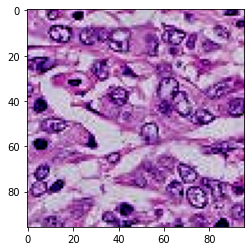

In [34]:
train_data = read_data(0, False)
print(np.array(train_data['x']).shape)
plt.imshow(np.array(train_data['x'])[0].transpose(1,2,0))

Resnet Client Class Definition

In [6]:
import timeit
from copy import deepcopy
from torchvision.models import resnet18
from flwr.common import (
    Code,
    EvaluateIns,
    EvaluateRes,
    FitIns,
    FitRes,
    GetParametersIns,
    GetParametersRes,
    Status,
    ndarrays_to_parameters,
    parameters_to_ndarrays,
)
def get_weights(model: torch.nn.ModuleList) -> fl.common.NDArrays:
    """Get model weights as a list of NumPy ndarrays."""
    return [val.cpu().numpy() for _, val in model.state_dict().items()]


def set_weights(model: torch.nn.ModuleList, weights: fl.common.NDArrays) -> None:
    """Set model weights from a list of NumPy ndarrays."""
    state_dict = OrderedDict(
        {
            k: torch.tensor(np.atleast_1d(v))
            for k, v in zip(model.state_dict().keys(), weights)
        }
    )
    model.load_state_dict(state_dict, strict=True)


class ResnetClient(fl.client.Client):
    """Flower client implementing ImageNet image classification using PyTorch."""

    def __init__(
        self,
        cid: str,
        trainloader: torch.utils.data.DataLoader,
        testloader: torch.utils.data.DataLoader,
        nb_clients: int,
        
    ) -> None:
        self.cid = cid
        self.model = resnet18().to(DEVICE)
        self.trainloader = trainloader
        self.testloader = testloader
        self.nb_clients = nb_clients
        
        self.prev_model = None
        self.wa = None
        self.wa_updated = None
        self.soup_avg= None
        self.soup_avg_num = 0
        

    def get_parameters(self, config): #-> fl.common.ParametersRes:
        print(f"Client {self.cid}: get_parameters")
        weights: fl.common.NDArrays = get_weights(self.model)
        parameters = fl.common.ndarrays_to_parameters(weights)
        status = Status(code=Code.OK, message="Success")
        return GetParametersRes(
            status=status,
            parameters=parameters,
        )

    def fit(self, ins: fl.common.FitIns): #-> fl.common.FitRes:
        # Set the seed so we are sure to generate the same global batches
        # indices across all clients
        np.random.seed(123)

        print(f"Client {self.cid}: fit")

        weights: fl.common.NDArrays = fl.common.parameters_to_ndarrays(ins.parameters)
        config = ins.config
        fit_begin = timeit.default_timer()

        print(config)
        total_rounds = config["total_rounds"]
        alpha = config["alpha"]
        train_round = config["server_round"]
        # # Get training config
        # epochs = int(config["epochs"])
        # batch_size = int(config["batch_size"])

        # Set model parameters
        set_weights(self.model, weights)


        #copying prev iteration
        self.prev_model = deepcopy(self.model)
        self.prev_model.load_state_dict(self.model.state_dict())

        
        train(self.model, self.trainloader, epochs=1)
        if train_round > alpha * total_rounds:
            print("Weight Averaging......")
            if self.soup_avg_num == 0:
                self.soup_avg = deepcopy(self.model)
                self.soup_avg.load_state_dict(
                    self.prev_model.state_dict()
                )

            self.wa = deepcopy(self.model)
            self.wa_updated = deepcopy(self.model)

            self.wa.load_state_dict(self.model.state_dict())
            self.wa_updated.load_state_dict(self.model.state_dict())

            
            # lets explain step by step what is happening here
            
            for wa_param, u_wa_param, soup_param, prev_model in zip(  # we are iterating over the parameters of the models (wa, u_wa, soup, prev_model)
                self.wa.parameters(),
                self.wa_updated.parameters(),
                self.soup_avg.parameters(),
                self.prev_model.parameters(),
            ):
                # updating the parameters of the updated weight averaging model
                wa_param.data = wa_param.data.clone() * (
                    1.0 / (self.soup_avg_num + 1.0)
                ) + soup_param.data.clone() * (
                    self.soup_avg_num / (self.soup_avg_num + 1.0)
                )
                # updating the parameters of the updated weight averaging model
                u_wa_param.data = (
                    u_wa_param.data.clone() * (1.0 / (self.soup_avg_num + 2.0))
                    + soup_param.data.clone()
                    * (self.soup_avg_num / (self.soup_avg_num + 2.0))
                    + prev_model.data.clone()
                    * (1.0 / (self.soup_avg_num + 2.0))
                )
                # preparing for updated per_global_model
                prev_model.data = (1.0 / (self.soup_avg_num + 1.0)) * (
                    self.soup_avg_num * soup_param.data.clone()
                    + prev_model.data.clone()
                )

            # local_acc = self.quick_test(self.model)
            # we obtain the accuracy of the original weight averaging model and the updated weight averaging model
            _, wa_acc = test(self.wa, self.testloader)
            _, update_wa_acc = test(self.wa_updated, self.testloader)
            # print("Local Accuracy: ", local_acc)
            print("Original Weight Averaging Accuracy: ", wa_acc)
            print("Updated Weight Averaging Accuracy: ", update_wa_acc)
            # we update the global model with the updated weight averaging model if the updated weight averaging model has a better accuracy
            if update_wa_acc > wa_acc:
                print("Update Personalized Global Model......")
                self.model.load_state_dict(self.wa_updated.state_dict())
                self.soup_avg.load_state_dict(
                    self.prev_model.state_dict()
                )
                self.soup_avg_num += 1
                print("Personalized Global Model Num: ", self.soup_avg_num)
            else:
                print("Remain the same Personalized Global Model.")
                self.model.load_state_dict(self.wa.state_dict())
            del self.prev_model, self.wa, self.wa_updated

        # Return the refined weights and the number of examples used for training
        weights_prime: fl.common.NDArrays = get_weights(self.model)
        params_prime = fl.common.ndarrays_to_parameters(weights_prime)     
        status = Status(code=Code.OK, message="Success")
        return FitRes(
            status=status,
            parameters=params_prime,
            num_examples=len(self.trainloader),
            metrics={},
        )

    def evaluate(self, ins: fl.common.EvaluateIns) -> fl.common.EvaluateRes:
        # Set the set so we are sure to generate the same batches
        # across all clients.
        np.random.seed(123)

        print(f"Client {self.cid}: evaluate")

        # config = ins.config
        # batch_size = int(config["batch_size"])

        weights = fl.common.parameters_to_ndarrays(ins.parameters)

        # Use provided weights to update the local model
        set_weights(self.model, weights)
        loss, accuracy = test(self.model, self.testloader)
        status = Status(code=Code.OK, message="Success")
        # Return the number of evaluation examples and the evaluation result (loss)
        #print("im")
        return fl.common.EvaluateRes(
            status=status,
            loss=float(loss),
            num_examples=len(self.testloader),
            metrics = {"accuracy": float(accuracy),"loss": float(loss)},
        )

In [35]:
class ResnetClientAvg(fl.client.Client):
    """Flower client implementing ImageNet image classification using PyTorch."""

    def __init__(
        self,
        cid: str,
        trainloader: torch.utils.data.DataLoader,
        testloader: torch.utils.data.DataLoader,
        nb_clients: int,
        
    ) -> None:
        self.cid = cid
        self.model = resnet18().to(DEVICE)
        self.trainloader = trainloader
        self.testloader = testloader
        self.nb_clients = nb_clients
        
        

    def get_parameters(self, config): #-> fl.common.ParametersRes:
        print(f"Client {self.cid}: get_parameters")
        weights: fl.common.NDArrays = get_weights(self.model)
        parameters = fl.common.ndarrays_to_parameters(weights)
        status = Status(code=Code.OK, message="Success")
        return GetParametersRes(
            status=status,
            parameters=parameters,
        )

    def fit(self, ins: fl.common.FitIns): #-> fl.common.FitRes:
        # Set the seed so we are sure to generate the same global batches
        # indices across all clients
        np.random.seed(123)

        print(f"Client {self.cid}: fit")

        weights: fl.common.NDArrays = fl.common.parameters_to_ndarrays(ins.parameters)
        config = ins.config
        fit_begin = timeit.default_timer()

        print(config)
        total_rounds = config["total_rounds"]
        alpha = config["alpha"]
        train_round = config["server_round"]
        # # Get training config
        # epochs = int(config["epochs"])
        # batch_size = int(config["batch_size"])

        # Set model parameters
        set_weights(self.model, weights)


        
        train(self.model, self.trainloader, epochs=1)
        

        # Return the refined weights and the number of examples used for training
        weights_prime: fl.common.NDArrays = get_weights(self.model)
        params_prime = fl.common.ndarrays_to_parameters(weights_prime)     
        status = Status(code=Code.OK, message="Success")
        return FitRes(
            status=status,
            parameters=params_prime,
            num_examples=len(self.trainloader),
            metrics={},
        )

    def evaluate(self, ins: fl.common.EvaluateIns) -> fl.common.EvaluateRes:
        # Set the set so we are sure to generate the same batches
        # across all clients.
        np.random.seed(123)

        print(f"Client {self.cid}: evaluate")

        # config = ins.config
        # batch_size = int(config["batch_size"])

        weights = fl.common.parameters_to_ndarrays(ins.parameters)

        # Use provided weights to update the local model
        set_weights(self.model, weights)
        loss, accuracy = test(self.model, self.testloader)
        status = Status(code=Code.OK, message="Success")
        # Return the number of evaluation examples and the evaluation result (loss)
        #print("im")
        return fl.common.EvaluateRes(
            status=status,
            loss=float(loss),
            num_examples=len(self.testloader),
            metrics = {"accuracy": float(accuracy),"loss": float(loss)},
        )

In [36]:
def get_on_fit_config_fn(total_rounds, alpha):
    def fit_config(server_round: int):
        config = {
            "alpha": alpha,
            "total_rounds":total_rounds,
            "server_round": server_round,
        }
        return config
    return fit_config

In [37]:
from flwr.common import Metrics
def weighted_average(metrics: List[Tuple[int, Metrics]]) -> Metrics:
    # Multiply accuracy of each client by number of examples used
    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]

    # Aggregate and return custom metric (weighted average)
    return {"accuracy": sum(accuracies) / sum(examples)}


In [38]:
def create_global_testset():
    global_xtest, global_ytest = [], []
    for client in range(5):
        data = read_data(client, False)
        xtest, ytest = np.array(data['x']), data['y']
        # take random 20% of the data
        _, xtest, _, ytest = train_test_split(xtest, ytest, test_size=0.2, random_state=42, stratify=ytest)
        global_xtest.append(xtest)
        global_ytest.append(ytest)
        
    global_xtest = np.concatenate(global_xtest)
    global_ytest = np.concatenate(global_ytest) 
    global_test_dataset = torch.utils.data.TensorDataset(torch.from_numpy(global_xtest), torch.from_numpy(global_ytest))
    global_testloader = DataLoader(global_test_dataset, batch_size=16)
    return global_testloader

In [72]:
from sklearn.manifold import TSNE
def apply_tsne(features):
    features_np = features.numpy()
    tsne = TSNE(n_components=2, random_state=0).fit_transform(features_np)
    return tsne

def plot_tsne(tsne, labels):
    plt.figure(figsize=(10, 10))
    plt.scatter(tsne[:, 0], tsne[:, 1], c=labels, cmap=plt.cm.get_cmap("jet", 10))
    plt.colorbar(ticks=range(10))
    plt.clim(-0.5, 9.5)
    plt.show()
    
def extract_features_from_dataloader(dataloader, model):
    all_features = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            features = model(images)
            all_features.append(features.cpu())
            all_labels.append(labels.cpu())
    
    all_features = torch.cat(all_features, dim=0)
    all_labels = torch.cat(all_labels, dim=0)
    return all_features, all_labels

In [111]:
testloaderglobal = create_global_testset()
tsnes = []
def get_evaluate_fn(model):
    def evaluate(server_round: int, parameters: fl.common.NDArrays, config: Dict[str, Scalar]) -> Optional[Metrics]:
        global testloaderglobal
        global tsnes
        global global_last_model
        global total_rounds
        set_weights(model, parameters)
        loss, accuracy = test(model, testloaderglobal)
        
        if server_round % 10 == 0:
            features, labels = extract_features_from_dataloader(testloaderglobal, model)
            tsne = apply_tsne(features)
            tsnes.append(tsne)
            plot_tsne(tsne, labels)
            
        if server_round == total_rounds - 1:
            torch.save(model.state_dict(), "global_model.pt")
            global_last_model = model
            
        
        return loss, {"global_accuracy": accuracy}
    return evaluate

In [54]:
# define numpy client function with resnet
NUM_CLIENTS = 5
trainloaders, valloaders, testloaders = load_datasets(NUM_CLIENTS, val=True)
def numpyclient_fn(cid) -> ResnetClient:
    trainloader = trainloaders[int(cid)]
    testloader = valloaders[int(cid)]
    return ResnetClient(cid, trainloader, testloader, 1)


def numpyclient_fn_avg(cid) -> ResnetClientAvg:
    trainloader = trainloaders[int(cid)]
    testloader = testloaders[int(cid)]
    return ResnetClientAvg(cid, trainloader, testloader, 1)

In [65]:
def numpyclient_fn_avg(cid) -> ResnetClientAvg:
    trainloader = trainloaders[int(cid)]
    testloader = valloaders[int(cid)]
    return ResnetClientAvg(cid, trainloader, testloader, 1)

INFO flwr 2023-12-13 14:07:37,964 | app.py:178 | Starting Flower simulation, config: ServerConfig(num_rounds=40, round_timeout=None)
2023-12-13 14:07:46,318	INFO worker.py:1621 -- Started a local Ray instance.
INFO flwr 2023-12-13 14:07:49,808 | app.py:213 | Flower VCE: Ray initialized with resources: {'node:__internal_head__': 1.0, 'memory': 13335389799.0, 'node:127.0.0.1': 1.0, 'object_store_memory': 6667694899.0, 'CPU': 16.0, 'GPU': 1.0}
INFO flwr 2023-12-13 14:07:49,809 | app.py:219 | Optimize your simulation with Flower VCE: https://flower.dev/docs/framework/how-to-run-simulations.html
C:\Users\HamadAlHammadi\AppData\Local\Temp\ipykernel_94224\2897431122.py:12: UserWarning: No `num_cpus` specified in `client_resources`. Using `num_cpus=1` for each client.
  hist = fl.simulation.start_simulation(
INFO flwr 2023-12-13 14:07:49,809 | app.py:242 | Flower VCE: Resources for each Virtual Client: {'num_gpus': 1, 'num_cpus': 1}
INFO flwr 2023-12-13 14:07:49,817 | app.py:288 | Flower VCE: 

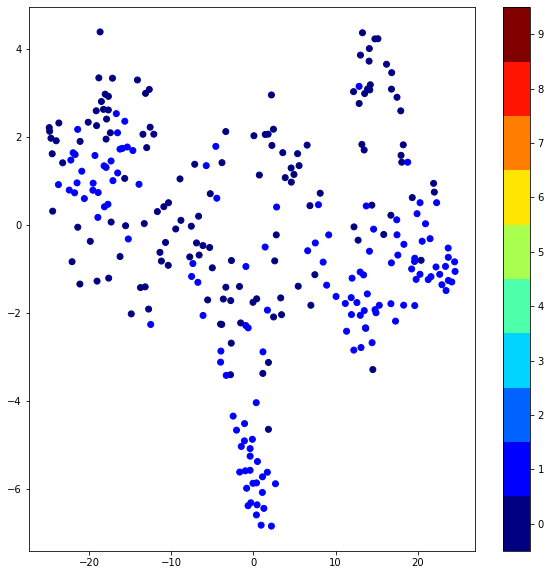

INFO flwr 2023-12-13 14:07:51,459 | server.py:94 | initial parameters (loss, other metrics): 0.4570330262184143, {'global_accuracy': 0.0}
INFO flwr 2023-12-13 14:07:51,459 | server.py:104 | FL starting
DEBUG flwr 2023-12-13 14:07:51,460 | server.py:222 | fit_round 1: strategy sampled 5 clients (out of 5)


(DefaultActor pid=67176) Client 4: fit
(DefaultActor pid=67176) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 1}
(DefaultActor pid=67176) Epoch 1: train loss 0.0970548540353775, accuracy 0.6729166666666667
(DefaultActor pid=67176) Client 0: fit
(DefaultActor pid=67176) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 1}
(DefaultActor pid=67176) Epoch 1: train loss 0.06768735498189926, accuracy 0.8083333333333333
(DefaultActor pid=67176) Client 2: fit
(DefaultActor pid=67176) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 1}
(DefaultActor pid=67176) Epoch 1: train loss 0.06751701235771179, accuracy 0.8229166666666666
(DefaultActor pid=67176) Client 3: fit
(DefaultActor pid=67176) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 1}
(DefaultActor pid=67176) Epoch 1: train loss 0.07076501846313477, accuracy 0.7791666666666667
(DefaultActor pid=67176) Client 1: fit
(DefaultActor pid=67176) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 1}


DEBUG flwr 2023-12-13 14:08:10,043 | server.py:236 | fit_round 1 received 5 results and 0 failures


(DefaultActor pid=67176) Epoch 1: train loss 0.07311595976352692, accuracy 0.7708333333333334


WARNING flwr 2023-12-13 14:08:10,338 | fedavg.py:242 | No fit_metrics_aggregation_fn provided
INFO flwr 2023-12-13 14:08:10,549 | server.py:125 | fit progress: (1, 0.06805752984115056, {'global_accuracy': 0.5}, 19.089057100005448)
DEBUG flwr 2023-12-13 14:08:10,550 | server.py:173 | evaluate_round 1: strategy sampled 5 clients (out of 5)


(DefaultActor pid=67176) Client 4: evaluate
(DefaultActor pid=67176) Client 2: evaluate
(DefaultActor pid=67176) Client 3: evaluate
(DefaultActor pid=67176) Client 0: evaluate
(DefaultActor pid=67176) Client 1: evaluate


DEBUG flwr 2023-12-13 14:08:16,672 | server.py:187 | evaluate_round 1 received 5 results and 0 failures
DEBUG flwr 2023-12-13 14:08:16,674 | server.py:222 | fit_round 2: strategy sampled 5 clients (out of 5)


(DefaultActor pid=67176) Client 4: fit
(DefaultActor pid=67176) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 2}
(DefaultActor pid=67176) Epoch 1: train loss 0.03139472007751465, accuracy 0.7854166666666667
(DefaultActor pid=67176) Client 3: fit
(DefaultActor pid=67176) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 2}
(DefaultActor pid=67176) Epoch 1: train loss 0.03496238961815834, accuracy 0.7791666666666667
(DefaultActor pid=67176) Client 1: fit
(DefaultActor pid=67176) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 2}
(DefaultActor pid=67176) Epoch 1: train loss 0.027625516057014465, accuracy 0.8208333333333333
(DefaultActor pid=67176) Client 0: fit
(DefaultActor pid=67176) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 2}
(DefaultActor pid=67176) Epoch 1: train loss 0.021378029137849808, accuracy 0.8666666666666667
(DefaultActor pid=67176) Client 2: fit
(DefaultActor pid=67176) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 2}


DEBUG flwr 2023-12-13 14:08:26,429 | server.py:236 | fit_round 2 received 5 results and 0 failures


(DefaultActor pid=67176) Epoch 1: train loss 0.03194938227534294, accuracy 0.80625


INFO flwr 2023-12-13 14:08:26,967 | server.py:125 | fit progress: (2, 0.04234257127557482, {'global_accuracy': 0.6642857142857143}, 35.506384500011336)
DEBUG flwr 2023-12-13 14:08:26,968 | server.py:173 | evaluate_round 2: strategy sampled 5 clients (out of 5)


(DefaultActor pid=67176) Client 1: evaluate
(DefaultActor pid=67176) Client 4: evaluate
(DefaultActor pid=67176) Client 2: evaluate
(DefaultActor pid=67176) Client 0: evaluate


DEBUG flwr 2023-12-13 14:08:33,127 | server.py:187 | evaluate_round 2 received 5 results and 0 failures
DEBUG flwr 2023-12-13 14:08:33,129 | server.py:222 | fit_round 3: strategy sampled 5 clients (out of 5)


(DefaultActor pid=67176) Client 3: evaluate
(DefaultActor pid=67176) Client 1: fit
(DefaultActor pid=67176) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 3}
(DefaultActor pid=67176) Epoch 1: train loss 0.027289288118481636, accuracy 0.8395833333333333
(DefaultActor pid=67176) Client 2: fit
(DefaultActor pid=67176) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 3}
(DefaultActor pid=67176) Epoch 1: train loss 0.024718377739191055, accuracy 0.8291666666666667
(DefaultActor pid=67176) Client 3: fit
(DefaultActor pid=67176) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 3}
(DefaultActor pid=67176) Epoch 1: train loss 0.025260962545871735, accuracy 0.8375
(DefaultActor pid=67176) Client 4: fit
(DefaultActor pid=67176) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 3}
(DefaultActor pid=67176) Epoch 1: train loss 0.037573862820863724, accuracy 0.7166666666666667
(DefaultActor pid=67176) Client 0: fit
(DefaultActor pid=67176) {'alpha': 0.75, 'total_rounds': 40, 'server_roun

DEBUG flwr 2023-12-13 14:08:43,448 | server.py:236 | fit_round 3 received 5 results and 0 failures


(DefaultActor pid=67176) Epoch 1: train loss 0.02477142959833145, accuracy 0.8458333333333333


INFO flwr 2023-12-13 14:08:43,960 | server.py:125 | fit progress: (3, 0.045414671088968, {'global_accuracy': 0.6785714285714286}, 52.4998489000136)
DEBUG flwr 2023-12-13 14:08:43,961 | server.py:173 | evaluate_round 3: strategy sampled 5 clients (out of 5)


(DefaultActor pid=67176) Client 0: evaluate
(DefaultActor pid=67176) Client 3: evaluate
(DefaultActor pid=67176) Client 2: evaluate
(DefaultActor pid=67176) Client 4: evaluate


DEBUG flwr 2023-12-13 14:08:50,321 | server.py:187 | evaluate_round 3 received 5 results and 0 failures
DEBUG flwr 2023-12-13 14:08:50,322 | server.py:222 | fit_round 4: strategy sampled 5 clients (out of 5)


(DefaultActor pid=67176) Client 1: evaluate
(DefaultActor pid=67176) Client 3: fit
(DefaultActor pid=67176) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 4}
(DefaultActor pid=67176) Epoch 1: train loss 0.025607217103242874, accuracy 0.8395833333333333
(DefaultActor pid=67176) Client 4: fit
(DefaultActor pid=67176) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 4}
(DefaultActor pid=67176) Epoch 1: train loss 0.03209422156214714, accuracy 0.7854166666666667
(DefaultActor pid=67176) Client 2: fit
(DefaultActor pid=67176) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 4}
(DefaultActor pid=67176) Epoch 1: train loss 0.022640982642769814, accuracy 0.8729166666666667
(DefaultActor pid=67176) Client 1: fit
(DefaultActor pid=67176) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 4}
(DefaultActor pid=67176) Epoch 1: train loss 0.022555924952030182, accuracy 0.8770833333333333
(DefaultActor pid=67176) Client 0: fit
(DefaultActor pid=67176) {'alpha': 0.75, 'total_rounds': 40, '

DEBUG flwr 2023-12-13 14:09:00,451 | server.py:236 | fit_round 4 received 5 results and 0 failures


(DefaultActor pid=67176) Epoch 1: train loss 0.020692629739642143, accuracy 0.88125


INFO flwr 2023-12-13 14:09:00,985 | server.py:125 | fit progress: (4, 0.043713467834251264, {'global_accuracy': 0.6892857142857143}, 69.52385729999514)
DEBUG flwr 2023-12-13 14:09:00,986 | server.py:173 | evaluate_round 4: strategy sampled 5 clients (out of 5)


(DefaultActor pid=67176) Client 4: evaluate
(DefaultActor pid=67176) Client 2: evaluate
(DefaultActor pid=67176) Client 0: evaluate
(DefaultActor pid=67176) Client 1: evaluate


DEBUG flwr 2023-12-13 14:09:07,331 | server.py:187 | evaluate_round 4 received 5 results and 0 failures
DEBUG flwr 2023-12-13 14:09:07,331 | server.py:222 | fit_round 5: strategy sampled 5 clients (out of 5)


(DefaultActor pid=67176) Client 3: evaluate
(DefaultActor pid=67176) Client 1: fit
(DefaultActor pid=67176) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 5}
(DefaultActor pid=67176) Epoch 1: train loss 0.02367623709142208, accuracy 0.8479166666666667
(DefaultActor pid=67176) Client 4: fit
(DefaultActor pid=67176) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 5}
(DefaultActor pid=67176) Epoch 1: train loss 0.029050596058368683, accuracy 0.7854166666666667
(DefaultActor pid=67176) Client 2: fit
(DefaultActor pid=67176) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 5}
(DefaultActor pid=67176) Epoch 1: train loss 0.022612623870372772, accuracy 0.88125
(DefaultActor pid=67176) Client 0: fit
(DefaultActor pid=67176) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 5}
(DefaultActor pid=67176) Epoch 1: train loss 0.019532430917024612, accuracy 0.89375
(DefaultActor pid=67176) Client 3: fit
(DefaultActor pid=67176) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 5}


DEBUG flwr 2023-12-13 14:09:17,730 | server.py:236 | fit_round 5 received 5 results and 0 failures


(DefaultActor pid=67176) Epoch 1: train loss 0.020701052621006966, accuracy 0.8645833333333334


INFO flwr 2023-12-13 14:09:18,266 | server.py:125 | fit progress: (5, 0.035097130121929304, {'global_accuracy': 0.7464285714285714}, 86.80574430001434)
DEBUG flwr 2023-12-13 14:09:18,267 | server.py:173 | evaluate_round 5: strategy sampled 5 clients (out of 5)


(DefaultActor pid=67176) Client 2: evaluate
(DefaultActor pid=67176) Client 1: evaluate
(DefaultActor pid=67176) Client 0: evaluate
(DefaultActor pid=67176) Client 3: evaluate


DEBUG flwr 2023-12-13 14:09:24,677 | server.py:187 | evaluate_round 5 received 5 results and 0 failures
DEBUG flwr 2023-12-13 14:09:24,678 | server.py:222 | fit_round 6: strategy sampled 5 clients (out of 5)


(DefaultActor pid=67176) Client 4: evaluate
(DefaultActor pid=67176) Client 3: fit
(DefaultActor pid=67176) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 6}
(DefaultActor pid=67176) Epoch 1: train loss 0.022764498367905617, accuracy 0.8604166666666667
(DefaultActor pid=67176) Client 4: fit
(DefaultActor pid=67176) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 6}
(DefaultActor pid=67176) Epoch 1: train loss 0.02526193857192993, accuracy 0.81875
(DefaultActor pid=67176) Client 2: fit
(DefaultActor pid=67176) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 6}
(DefaultActor pid=67176) Epoch 1: train loss 0.021272651851177216, accuracy 0.8666666666666667
(DefaultActor pid=67176) Client 1: fit
(DefaultActor pid=67176) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 6}
(DefaultActor pid=67176) Epoch 1: train loss 0.0261060893535614, accuracy 0.83125
(DefaultActor pid=67176) Client 0: fit
(DefaultActor pid=67176) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 6}


DEBUG flwr 2023-12-13 14:09:34,766 | server.py:236 | fit_round 6 received 5 results and 0 failures


(DefaultActor pid=67176) Epoch 1: train loss 0.019477998837828636, accuracy 0.8854166666666666


INFO flwr 2023-12-13 14:09:35,317 | server.py:125 | fit progress: (6, 0.03436874385390963, {'global_accuracy': 0.7}, 103.85670479998225)
DEBUG flwr 2023-12-13 14:09:35,317 | server.py:173 | evaluate_round 6: strategy sampled 5 clients (out of 5)


(DefaultActor pid=67176) Client 2: evaluate
(DefaultActor pid=67176) Client 1: evaluate
(DefaultActor pid=67176) Client 3: evaluate
(DefaultActor pid=67176) Client 0: evaluate
(DefaultActor pid=67176) Client 4: evaluate


DEBUG flwr 2023-12-13 14:09:41,882 | server.py:187 | evaluate_round 6 received 5 results and 0 failures
DEBUG flwr 2023-12-13 14:09:41,883 | server.py:222 | fit_round 7: strategy sampled 5 clients (out of 5)


(DefaultActor pid=67176) Client 4: fit
(DefaultActor pid=67176) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 7}
(DefaultActor pid=67176) Epoch 1: train loss 0.027615563943982124, accuracy 0.8125
(DefaultActor pid=67176) Client 3: fit
(DefaultActor pid=67176) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 7}
(DefaultActor pid=67176) Epoch 1: train loss 0.02108941599726677, accuracy 0.8729166666666667
(DefaultActor pid=67176) Client 1: fit
(DefaultActor pid=67176) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 7}
(DefaultActor pid=67176) Epoch 1: train loss 0.018718352541327477, accuracy 0.8854166666666666
(DefaultActor pid=67176) Client 2: fit
(DefaultActor pid=67176) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 7}
(DefaultActor pid=67176) Epoch 1: train loss 0.02054360881447792, accuracy 0.88125
(DefaultActor pid=67176) Client 0: fit
(DefaultActor pid=67176) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 7}


DEBUG flwr 2023-12-13 14:09:52,593 | server.py:236 | fit_round 7 received 5 results and 0 failures


(DefaultActor pid=67176) Epoch 1: train loss 0.01747913658618927, accuracy 0.8895833333333333


INFO flwr 2023-12-13 14:09:53,120 | server.py:125 | fit progress: (7, 0.02806442677974701, {'global_accuracy': 0.7892857142857143}, 121.65903360000812)
DEBUG flwr 2023-12-13 14:09:53,121 | server.py:173 | evaluate_round 7: strategy sampled 5 clients (out of 5)


(DefaultActor pid=67176) Client 2: evaluate
(DefaultActor pid=67176) Client 3: evaluate
(DefaultActor pid=67176) Client 0: evaluate
(DefaultActor pid=67176) Client 1: evaluate


DEBUG flwr 2023-12-13 14:09:59,435 | server.py:187 | evaluate_round 7 received 5 results and 0 failures
DEBUG flwr 2023-12-13 14:09:59,435 | server.py:222 | fit_round 8: strategy sampled 5 clients (out of 5)


(DefaultActor pid=67176) Client 4: evaluate
(DefaultActor pid=67176) Client 0: fit
(DefaultActor pid=67176) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 8}
(DefaultActor pid=67176) Epoch 1: train loss 0.01561212819069624, accuracy 0.8979166666666667
(DefaultActor pid=67176) Client 2: fit
(DefaultActor pid=67176) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 8}
(DefaultActor pid=67176) Epoch 1: train loss 0.0172068253159523, accuracy 0.8833333333333333
(DefaultActor pid=67176) Client 3: fit
(DefaultActor pid=67176) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 8}
(DefaultActor pid=67176) Epoch 1: train loss 0.025351017713546753, accuracy 0.8291666666666667
(DefaultActor pid=67176) Client 4: fit
(DefaultActor pid=67176) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 8}
(DefaultActor pid=67176) Epoch 1: train loss 0.027065789327025414, accuracy 0.7895833333333333
(DefaultActor pid=67176) Client 1: fit
(DefaultActor pid=67176) {'alpha': 0.75, 'total_rounds': 40, 'se

DEBUG flwr 2023-12-13 14:10:09,738 | server.py:236 | fit_round 8 received 5 results and 0 failures


(DefaultActor pid=67176) Epoch 1: train loss 0.018231548368930817, accuracy 0.88125


INFO flwr 2023-12-13 14:10:10,259 | server.py:125 | fit progress: (8, 0.029332732409238817, {'global_accuracy': 0.7892857142857143}, 138.79942819999997)
DEBUG flwr 2023-12-13 14:10:10,260 | server.py:173 | evaluate_round 8: strategy sampled 5 clients (out of 5)


(DefaultActor pid=67176) Client 3: evaluate
(DefaultActor pid=67176) Client 1: evaluate
(DefaultActor pid=67176) Client 0: evaluate
(DefaultActor pid=67176) Client 4: evaluate


DEBUG flwr 2023-12-13 14:10:16,497 | server.py:187 | evaluate_round 8 received 5 results and 0 failures
DEBUG flwr 2023-12-13 14:10:16,498 | server.py:222 | fit_round 9: strategy sampled 5 clients (out of 5)


(DefaultActor pid=67176) Client 2: evaluate
(DefaultActor pid=67176) Client 1: fit
(DefaultActor pid=67176) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 9}
(DefaultActor pid=67176) Epoch 1: train loss 0.021431276574730873, accuracy 0.8729166666666667
(DefaultActor pid=67176) Client 4: fit
(DefaultActor pid=67176) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 9}
(DefaultActor pid=67176) Epoch 1: train loss 0.027594728395342827, accuracy 0.8270833333333333
(DefaultActor pid=67176) Client 2: fit
(DefaultActor pid=67176) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 9}
(DefaultActor pid=67176) Epoch 1: train loss 0.014796001836657524, accuracy 0.9083333333333333
(DefaultActor pid=67176) Client 0: fit
(DefaultActor pid=67176) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 9}
(DefaultActor pid=67176) Epoch 1: train loss 0.016101403161883354, accuracy 0.9
(DefaultActor pid=67176) Client 3: fit
(DefaultActor pid=67176) {'alpha': 0.75, 'total_rounds': 40, 'server_round':

DEBUG flwr 2023-12-13 14:10:26,659 | server.py:236 | fit_round 9 received 5 results and 0 failures


(DefaultActor pid=67176) Epoch 1: train loss 0.01830388233065605, accuracy 0.8875


INFO flwr 2023-12-13 14:10:27,170 | server.py:125 | fit progress: (9, 0.0267811262181827, {'global_accuracy': 0.8}, 155.70940160000464)
DEBUG flwr 2023-12-13 14:10:27,171 | server.py:173 | evaluate_round 9: strategy sampled 5 clients (out of 5)


(DefaultActor pid=67176) Client 0: evaluate
(DefaultActor pid=67176) Client 4: evaluate
(DefaultActor pid=67176) Client 3: evaluate
(DefaultActor pid=67176) Client 2: evaluate


DEBUG flwr 2023-12-13 14:10:33,474 | server.py:187 | evaluate_round 9 received 5 results and 0 failures
DEBUG flwr 2023-12-13 14:10:33,475 | server.py:222 | fit_round 10: strategy sampled 5 clients (out of 5)


(DefaultActor pid=67176) Client 1: evaluate
(DefaultActor pid=67176) Client 1: fit
(DefaultActor pid=67176) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 10}
(DefaultActor pid=67176) Epoch 1: train loss 0.018393633887171745, accuracy 0.8791666666666667
(DefaultActor pid=67176) Client 4: fit
(DefaultActor pid=67176) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 10}
(DefaultActor pid=67176) Epoch 1: train loss 0.024487601593136787, accuracy 0.8416666666666667
(DefaultActor pid=67176) Client 3: fit
(DefaultActor pid=67176) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 10}
(DefaultActor pid=67176) Epoch 1: train loss 0.016184113919734955, accuracy 0.90625
(DefaultActor pid=67176) Client 2: fit
(DefaultActor pid=67176) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 10}
(DefaultActor pid=67176) Epoch 1: train loss 0.015781104564666748, accuracy 0.9125
(DefaultActor pid=67176) Client 0: fit
(DefaultActor pid=67176) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 10}

DEBUG flwr 2023-12-13 14:10:43,676 | server.py:236 | fit_round 10 received 5 results and 0 failures


(DefaultActor pid=67176) Epoch 1: train loss 0.015947073698043823, accuracy 0.88125


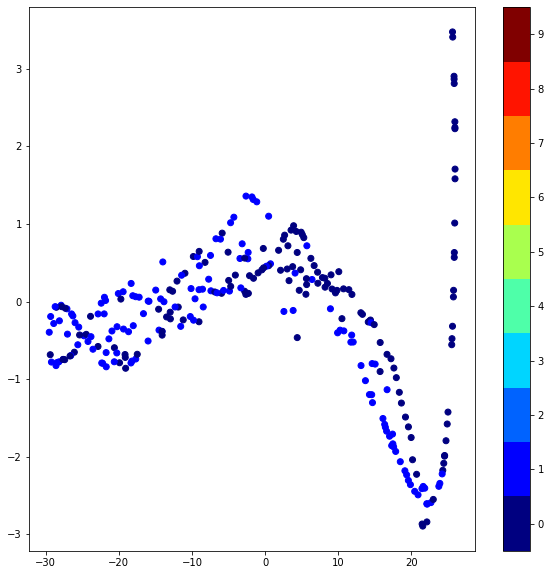

INFO flwr 2023-12-13 14:10:45,466 | server.py:125 | fit progress: (10, 0.030267205994044033, {'global_accuracy': 0.7607142857142857}, 174.00587629998336)
DEBUG flwr 2023-12-13 14:10:45,466 | server.py:173 | evaluate_round 10: strategy sampled 5 clients (out of 5)


(DefaultActor pid=67176) Client 1: evaluate
(DefaultActor pid=67176) Client 2: evaluate
(DefaultActor pid=67176) Client 4: evaluate
(DefaultActor pid=67176) Client 0: evaluate
(DefaultActor pid=67176) Client 3: evaluate


DEBUG flwr 2023-12-13 14:10:51,974 | server.py:187 | evaluate_round 10 received 5 results and 0 failures
DEBUG flwr 2023-12-13 14:10:51,976 | server.py:222 | fit_round 11: strategy sampled 5 clients (out of 5)


(DefaultActor pid=67176) Client 4: fit
(DefaultActor pid=67176) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 11}
(DefaultActor pid=67176) Epoch 1: train loss 0.024319006130099297, accuracy 0.83125
(DefaultActor pid=67176) Client 1: fit
(DefaultActor pid=67176) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 11}
(DefaultActor pid=67176) Epoch 1: train loss 0.022133512422442436, accuracy 0.8625
(DefaultActor pid=67176) Client 2: fit
(DefaultActor pid=67176) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 11}
(DefaultActor pid=67176) Epoch 1: train loss 0.014708418399095535, accuracy 0.9125
(DefaultActor pid=67176) Client 0: fit
(DefaultActor pid=67176) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 11}
(DefaultActor pid=67176) Epoch 1: train loss 0.01713312417268753, accuracy 0.9125
(DefaultActor pid=67176) Client 3: fit
(DefaultActor pid=67176) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 11}


DEBUG flwr 2023-12-13 14:11:02,799 | server.py:236 | fit_round 11 received 5 results and 0 failures


(DefaultActor pid=67176) Epoch 1: train loss 0.016679489985108376, accuracy 0.9083333333333333


INFO flwr 2023-12-13 14:11:03,378 | server.py:125 | fit progress: (11, 0.024810786385621342, {'global_accuracy': 0.8214285714285714}, 191.9186976000201)
DEBUG flwr 2023-12-13 14:11:03,379 | server.py:173 | evaluate_round 11: strategy sampled 5 clients (out of 5)


(DefaultActor pid=67176) Client 4: evaluate
(DefaultActor pid=67176) Client 2: evaluate
(DefaultActor pid=67176) Client 3: evaluate
(DefaultActor pid=67176) Client 1: evaluate


DEBUG flwr 2023-12-13 14:11:10,592 | server.py:187 | evaluate_round 11 received 5 results and 0 failures
DEBUG flwr 2023-12-13 14:11:10,593 | server.py:222 | fit_round 12: strategy sampled 5 clients (out of 5)


(DefaultActor pid=67176) Client 0: evaluate
(DefaultActor pid=67176) Client 3: fit
(DefaultActor pid=67176) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 12}
(DefaultActor pid=67176) Epoch 1: train loss 0.021478524431586266, accuracy 0.86875
(DefaultActor pid=67176) Client 4: fit
(DefaultActor pid=67176) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 12}
(DefaultActor pid=67176) Epoch 1: train loss 0.025683552026748657, accuracy 0.8520833333333333
(DefaultActor pid=67176) Client 2: fit
(DefaultActor pid=67176) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 12}
(DefaultActor pid=67176) Epoch 1: train loss 0.01845880039036274, accuracy 0.8958333333333334
(DefaultActor pid=67176) Client 1: fit
(DefaultActor pid=67176) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 12}
(DefaultActor pid=67176) Epoch 1: train loss 0.016321994364261627, accuracy 0.90625
(DefaultActor pid=67176) Client 0: fit
(DefaultActor pid=67176) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 12}

DEBUG flwr 2023-12-13 14:11:21,124 | server.py:236 | fit_round 12 received 5 results and 0 failures


(DefaultActor pid=67176) Epoch 1: train loss 0.013962891884148121, accuracy 0.9


INFO flwr 2023-12-13 14:11:21,678 | server.py:125 | fit progress: (12, 0.029469838472349304, {'global_accuracy': 0.7642857142857142}, 210.21799189999)
DEBUG flwr 2023-12-13 14:11:21,679 | server.py:173 | evaluate_round 12: strategy sampled 5 clients (out of 5)


(DefaultActor pid=67176) Client 3: evaluate
(DefaultActor pid=67176) Client 2: evaluate
(DefaultActor pid=67176) Client 1: evaluate
(DefaultActor pid=67176) Client 0: evaluate


DEBUG flwr 2023-12-13 14:11:28,069 | server.py:187 | evaluate_round 12 received 5 results and 0 failures
DEBUG flwr 2023-12-13 14:11:28,070 | server.py:222 | fit_round 13: strategy sampled 5 clients (out of 5)


(DefaultActor pid=67176) Client 4: evaluate
(DefaultActor pid=67176) Client 1: fit
(DefaultActor pid=67176) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 13}
(DefaultActor pid=67176) Epoch 1: train loss 0.017604684457182884, accuracy 0.8875
(DefaultActor pid=67176) Client 2: fit
(DefaultActor pid=67176) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 13}
(DefaultActor pid=67176) Epoch 1: train loss 0.013395755551755428, accuracy 0.9229166666666667
(DefaultActor pid=67176) Client 4: fit
(DefaultActor pid=67176) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 13}
(DefaultActor pid=67176) Epoch 1: train loss 0.022642329335212708, accuracy 0.8604166666666667
(DefaultActor pid=67176) Client 0: fit
(DefaultActor pid=67176) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 13}
(DefaultActor pid=67176) Epoch 1: train loss 0.01581800915300846, accuracy 0.9125
(DefaultActor pid=67176) Client 3: fit
(DefaultActor pid=67176) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 13}


DEBUG flwr 2023-12-13 14:11:38,365 | server.py:236 | fit_round 13 received 5 results and 0 failures


(DefaultActor pid=67176) Epoch 1: train loss 0.01859625242650509, accuracy 0.8958333333333334


INFO flwr 2023-12-13 14:11:38,892 | server.py:125 | fit progress: (13, 0.031130339551184858, {'global_accuracy': 0.7714285714285715}, 227.43247539998265)
DEBUG flwr 2023-12-13 14:11:38,893 | server.py:173 | evaluate_round 13: strategy sampled 5 clients (out of 5)


(DefaultActor pid=67176) Client 1: evaluate
(DefaultActor pid=67176) Client 2: evaluate
(DefaultActor pid=67176) Client 3: evaluate
(DefaultActor pid=67176) Client 0: evaluate


DEBUG flwr 2023-12-13 14:11:45,167 | server.py:187 | evaluate_round 13 received 5 results and 0 failures
DEBUG flwr 2023-12-13 14:11:45,168 | server.py:222 | fit_round 14: strategy sampled 5 clients (out of 5)


(DefaultActor pid=67176) Client 4: evaluate
(DefaultActor pid=67176) Client 1: fit
(DefaultActor pid=67176) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 14}
(DefaultActor pid=67176) Epoch 1: train loss 0.017503462731838226, accuracy 0.9020833333333333
(DefaultActor pid=67176) Client 3: fit
(DefaultActor pid=67176) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 14}
(DefaultActor pid=67176) Epoch 1: train loss 0.01429703924804926, accuracy 0.925
(DefaultActor pid=67176) Client 0: fit
(DefaultActor pid=67176) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 14}
(DefaultActor pid=67176) Epoch 1: train loss 0.017161991447210312, accuracy 0.8958333333333334
(DefaultActor pid=67176) Client 4: fit
(DefaultActor pid=67176) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 14}
(DefaultActor pid=67176) Epoch 1: train loss 0.027952732518315315, accuracy 0.825
(DefaultActor pid=67176) Client 2: fit
(DefaultActor pid=67176) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 14}


DEBUG flwr 2023-12-13 14:11:55,113 | server.py:236 | fit_round 14 received 5 results and 0 failures


(DefaultActor pid=67176) Epoch 1: train loss 0.013108721002936363, accuracy 0.9145833333333333


INFO flwr 2023-12-13 14:11:55,639 | server.py:125 | fit progress: (14, 0.02957062013447285, {'global_accuracy': 0.7928571428571428}, 244.1788932000054)
DEBUG flwr 2023-12-13 14:11:55,640 | server.py:173 | evaluate_round 14: strategy sampled 5 clients (out of 5)


(DefaultActor pid=67176) Client 4: evaluate
(DefaultActor pid=67176) Client 3: evaluate
(DefaultActor pid=67176) Client 2: evaluate
(DefaultActor pid=67176) Client 0: evaluate


DEBUG flwr 2023-12-13 14:12:02,190 | server.py:187 | evaluate_round 14 received 5 results and 0 failures
DEBUG flwr 2023-12-13 14:12:02,191 | server.py:222 | fit_round 15: strategy sampled 5 clients (out of 5)


(DefaultActor pid=67176) Client 1: evaluate
(DefaultActor pid=67176) Client 0: fit
(DefaultActor pid=67176) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 15}
(DefaultActor pid=67176) Epoch 1: train loss 0.014744830317795277, accuracy 0.9104166666666667
(DefaultActor pid=67176) Client 4: fit
(DefaultActor pid=67176) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 15}
(DefaultActor pid=67176) Epoch 1: train loss 0.025321025401353836, accuracy 0.8395833333333333
(DefaultActor pid=67176) Client 3: fit
(DefaultActor pid=67176) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 15}
(DefaultActor pid=67176) Epoch 1: train loss 0.017497003078460693, accuracy 0.9
(DefaultActor pid=67176) Client 1: fit
(DefaultActor pid=67176) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 15}
(DefaultActor pid=67176) Epoch 1: train loss 0.016322042793035507, accuracy 0.9020833333333333
(DefaultActor pid=67176) Client 2: fit
(DefaultActor pid=67176) {'alpha': 0.75, 'total_rounds': 40, 'server_rou

DEBUG flwr 2023-12-13 14:12:12,586 | server.py:236 | fit_round 15 received 5 results and 0 failures


(DefaultActor pid=67176) Epoch 1: train loss 0.01397615484893322, accuracy 0.9291666666666667


INFO flwr 2023-12-13 14:12:13,137 | server.py:125 | fit progress: (15, 0.026621431777519838, {'global_accuracy': 0.825}, 261.67685950000305)
DEBUG flwr 2023-12-13 14:12:13,139 | server.py:173 | evaluate_round 15: strategy sampled 5 clients (out of 5)


(DefaultActor pid=67176) Client 2: evaluate
(DefaultActor pid=67176) Client 1: evaluate
(DefaultActor pid=67176) Client 4: evaluate
(DefaultActor pid=67176) Client 3: evaluate


DEBUG flwr 2023-12-13 14:12:19,763 | server.py:187 | evaluate_round 15 received 5 results and 0 failures
DEBUG flwr 2023-12-13 14:12:19,764 | server.py:222 | fit_round 16: strategy sampled 5 clients (out of 5)


(DefaultActor pid=67176) Client 0: evaluate
(DefaultActor pid=67176) Client 1: fit
(DefaultActor pid=67176) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 16}
(DefaultActor pid=67176) Epoch 1: train loss 0.017886832356452942, accuracy 0.8833333333333333
(DefaultActor pid=67176) Client 4: fit
(DefaultActor pid=67176) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 16}
(DefaultActor pid=67176) Epoch 1: train loss 0.023966237902641296, accuracy 0.8375
(DefaultActor pid=67176) Client 0: fit
(DefaultActor pid=67176) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 16}
(DefaultActor pid=67176) Epoch 1: train loss 0.01105966791510582, accuracy 0.925
(DefaultActor pid=67176) Client 3: fit
(DefaultActor pid=67176) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 16}
(DefaultActor pid=67176) Epoch 1: train loss 0.01940872147679329, accuracy 0.8770833333333333
(DefaultActor pid=67176) Client 2: fit
(DefaultActor pid=67176) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 16}


DEBUG flwr 2023-12-13 14:12:33,523 | server.py:236 | fit_round 16 received 5 results and 0 failures


(DefaultActor pid=67176) Epoch 1: train loss 0.014203778468072414, accuracy 0.90625


INFO flwr 2023-12-13 14:12:34,112 | server.py:125 | fit progress: (16, 0.03871937245130539, {'global_accuracy': 0.6892857142857143}, 282.65114229999017)
DEBUG flwr 2023-12-13 14:12:34,113 | server.py:173 | evaluate_round 16: strategy sampled 5 clients (out of 5)


(DefaultActor pid=67176) Client 4: evaluate
(DefaultActor pid=67176) Client 0: evaluate
(DefaultActor pid=67176) Client 2: evaluate
(DefaultActor pid=67176) Client 3: evaluate
(DefaultActor pid=67176) Client 1: evaluate


DEBUG flwr 2023-12-13 14:12:41,497 | server.py:187 | evaluate_round 16 received 5 results and 0 failures
DEBUG flwr 2023-12-13 14:12:41,499 | server.py:222 | fit_round 17: strategy sampled 5 clients (out of 5)


(DefaultActor pid=67176) Client 4: fit
(DefaultActor pid=67176) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 17}
(DefaultActor pid=67176) Epoch 1: train loss 0.02354801446199417, accuracy 0.8666666666666667
(DefaultActor pid=67176) Client 0: fit
(DefaultActor pid=67176) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 17}
(DefaultActor pid=67176) Epoch 1: train loss 0.01447327435016632, accuracy 0.9229166666666667
(DefaultActor pid=67176) Client 2: fit
(DefaultActor pid=67176) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 17}
(DefaultActor pid=67176) Epoch 1: train loss 0.012756763957440853, accuracy 0.9333333333333333
(DefaultActor pid=67176) Client 3: fit
(DefaultActor pid=67176) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 17}
(DefaultActor pid=67176) Epoch 1: train loss 0.018737930804491043, accuracy 0.9083333333333333
(DefaultActor pid=67176) Client 1: fit
(DefaultActor pid=67176) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 17}


DEBUG flwr 2023-12-13 14:12:54,331 | server.py:236 | fit_round 17 received 5 results and 0 failures


(DefaultActor pid=67176) Epoch 1: train loss 0.017731616273522377, accuracy 0.9041666666666667


INFO flwr 2023-12-13 14:12:55,003 | server.py:125 | fit progress: (17, 0.028392550429063183, {'global_accuracy': 0.8321428571428572}, 303.5426650000154)
DEBUG flwr 2023-12-13 14:12:55,005 | server.py:173 | evaluate_round 17: strategy sampled 5 clients (out of 5)


(DefaultActor pid=67176) Client 2: evaluate
(DefaultActor pid=67176) Client 3: evaluate
(DefaultActor pid=67176) Client 0: evaluate
(DefaultActor pid=67176) Client 4: evaluate


DEBUG flwr 2023-12-13 14:13:03,884 | server.py:187 | evaluate_round 17 received 5 results and 0 failures
DEBUG flwr 2023-12-13 14:13:03,888 | server.py:222 | fit_round 18: strategy sampled 5 clients (out of 5)


(DefaultActor pid=67176) Client 1: evaluate
(DefaultActor pid=67176) Client 2: fit
(DefaultActor pid=67176) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 18}
(DefaultActor pid=67176) Epoch 1: train loss 0.019953737035393715, accuracy 0.9
(DefaultActor pid=67176) Client 0: fit
(DefaultActor pid=67176) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 18}
(DefaultActor pid=67176) Epoch 1: train loss 0.011585434898734093, accuracy 0.9354166666666667
(DefaultActor pid=67176) Client 3: fit
(DefaultActor pid=67176) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 18}
(DefaultActor pid=67176) Epoch 1: train loss 0.013187765143811703, accuracy 0.90625
(DefaultActor pid=67176) Client 1: fit
(DefaultActor pid=67176) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 18}
(DefaultActor pid=67176) Epoch 1: train loss 0.015206778421998024, accuracy 0.9104166666666667
(DefaultActor pid=67176) Client 4: fit
(DefaultActor pid=67176) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 18}


DEBUG flwr 2023-12-13 14:13:15,964 | server.py:236 | fit_round 18 received 5 results and 0 failures


(DefaultActor pid=67176) Epoch 1: train loss 0.021532543003559113, accuracy 0.86875


INFO flwr 2023-12-13 14:13:16,716 | server.py:125 | fit progress: (18, 0.030023020239812986, {'global_accuracy': 0.7571428571428571}, 325.25666469999123)
DEBUG flwr 2023-12-13 14:13:16,718 | server.py:173 | evaluate_round 18: strategy sampled 5 clients (out of 5)


(DefaultActor pid=67176) Client 2: evaluate
(DefaultActor pid=67176) Client 1: evaluate
(DefaultActor pid=67176) Client 4: evaluate
(DefaultActor pid=67176) Client 0: evaluate


DEBUG flwr 2023-12-13 14:13:23,600 | server.py:187 | evaluate_round 18 received 5 results and 0 failures
DEBUG flwr 2023-12-13 14:13:23,601 | server.py:222 | fit_round 19: strategy sampled 5 clients (out of 5)


(DefaultActor pid=67176) Client 3: evaluate
(DefaultActor pid=67176) Client 3: fit
(DefaultActor pid=67176) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 19}
(DefaultActor pid=67176) Epoch 1: train loss 0.01649213396012783, accuracy 0.9020833333333333
(DefaultActor pid=67176) Client 0: fit
(DefaultActor pid=67176) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 19}
(DefaultActor pid=67176) Epoch 1: train loss 0.018095867708325386, accuracy 0.89375
(DefaultActor pid=67176) Client 4: fit
(DefaultActor pid=67176) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 19}
(DefaultActor pid=67176) Epoch 1: train loss 0.022445453330874443, accuracy 0.8541666666666666
(DefaultActor pid=67176) Client 1: fit
(DefaultActor pid=67176) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 19}
(DefaultActor pid=67176) Epoch 1: train loss 0.015379359945654869, accuracy 0.9083333333333333
(DefaultActor pid=67176) Client 2: fit
(DefaultActor pid=67176) {'alpha': 0.75, 'total_rounds': 40, 'server_

DEBUG flwr 2023-12-13 14:13:34,508 | server.py:236 | fit_round 19 received 5 results and 0 failures


(DefaultActor pid=67176) Epoch 1: train loss 0.012142141349613667, accuracy 0.9291666666666667


INFO flwr 2023-12-13 14:13:35,097 | server.py:125 | fit progress: (19, 0.023714177177420685, {'global_accuracy': 0.8178571428571428}, 343.63658330001635)
DEBUG flwr 2023-12-13 14:13:35,098 | server.py:173 | evaluate_round 19: strategy sampled 5 clients (out of 5)


(DefaultActor pid=67176) Client 2: evaluate
(DefaultActor pid=67176) Client 1: evaluate
(DefaultActor pid=67176) Client 3: evaluate
(DefaultActor pid=67176) Client 4: evaluate
(DefaultActor pid=67176) Client 0: evaluate


DEBUG flwr 2023-12-13 14:13:44,436 | server.py:187 | evaluate_round 19 received 5 results and 0 failures
DEBUG flwr 2023-12-13 14:13:44,436 | server.py:222 | fit_round 20: strategy sampled 5 clients (out of 5)


(DefaultActor pid=67176) Client 0: fit
(DefaultActor pid=67176) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 20}
(DefaultActor pid=67176) Epoch 1: train loss 0.013684126548469067, accuracy 0.9229166666666667
(DefaultActor pid=67176) Client 1: fit
(DefaultActor pid=67176) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 20}
(DefaultActor pid=67176) Epoch 1: train loss 0.015613837167620659, accuracy 0.9166666666666666
(DefaultActor pid=67176) Client 2: fit
(DefaultActor pid=67176) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 20}
(DefaultActor pid=67176) Epoch 1: train loss 0.013315626420080662, accuracy 0.9270833333333334
(DefaultActor pid=67176) Client 4: fit
(DefaultActor pid=67176) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 20}
(DefaultActor pid=67176) Epoch 1: train loss 0.02492060326039791, accuracy 0.8729166666666667
(DefaultActor pid=67176) Client 3: fit
(DefaultActor pid=67176) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 20}


DEBUG flwr 2023-12-13 14:13:55,742 | server.py:236 | fit_round 20 received 5 results and 0 failures


(DefaultActor pid=67176) Epoch 1: train loss 0.013644150458276272, accuracy 0.9125


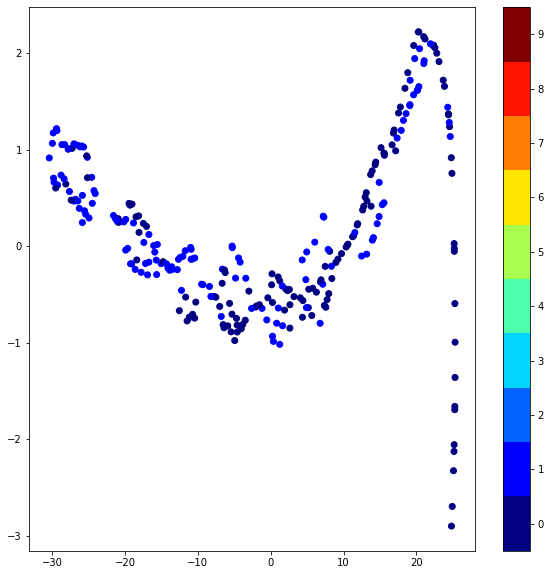

INFO flwr 2023-12-13 14:13:57,880 | server.py:125 | fit progress: (20, 0.026889445845569883, {'global_accuracy': 0.7892857142857143}, 366.41958509996766)
DEBUG flwr 2023-12-13 14:13:57,881 | server.py:173 | evaluate_round 20: strategy sampled 5 clients (out of 5)


(DefaultActor pid=67176) Client 0: evaluate
(DefaultActor pid=67176) Client 4: evaluate
(DefaultActor pid=67176) Client 3: evaluate
(DefaultActor pid=67176) Client 1: evaluate


DEBUG flwr 2023-12-13 14:14:05,350 | server.py:187 | evaluate_round 20 received 5 results and 0 failures
DEBUG flwr 2023-12-13 14:14:05,351 | server.py:222 | fit_round 21: strategy sampled 5 clients (out of 5)


(DefaultActor pid=67176) Client 2: evaluate
(DefaultActor pid=67176) Client 0: fit
(DefaultActor pid=67176) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 21}
(DefaultActor pid=67176) Epoch 1: train loss 0.010730172507464886, accuracy 0.9333333333333333
(DefaultActor pid=67176) Client 2: fit
(DefaultActor pid=67176) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 21}
(DefaultActor pid=67176) Epoch 1: train loss 0.012022166512906551, accuracy 0.9291666666666667
(DefaultActor pid=67176) Client 4: fit
(DefaultActor pid=67176) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 21}
(DefaultActor pid=67176) Epoch 1: train loss 0.020571943372488022, accuracy 0.8791666666666667
(DefaultActor pid=67176) Client 3: fit
(DefaultActor pid=67176) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 21}
(DefaultActor pid=67176) Epoch 1: train loss 0.013798913918435574, accuracy 0.9125
(DefaultActor pid=67176) Client 1: fit
(DefaultActor pid=67176) {'alpha': 0.75, 'total_rounds': 40, 'server_

DEBUG flwr 2023-12-13 14:14:17,612 | server.py:236 | fit_round 21 received 5 results and 0 failures


(DefaultActor pid=67176) Epoch 1: train loss 0.0180329792201519, accuracy 0.90625


INFO flwr 2023-12-13 14:14:18,174 | server.py:125 | fit progress: (21, 0.033815041131206924, {'global_accuracy': 0.7642857142857142}, 386.71374560002005)
DEBUG flwr 2023-12-13 14:14:18,174 | server.py:173 | evaluate_round 21: strategy sampled 5 clients (out of 5)


(DefaultActor pid=67176) Client 0: evaluate
(DefaultActor pid=67176) Client 4: evaluate
(DefaultActor pid=67176) Client 1: evaluate
(DefaultActor pid=67176) Client 3: evaluate
(DefaultActor pid=67176) Client 2: evaluate


DEBUG flwr 2023-12-13 14:14:24,818 | server.py:187 | evaluate_round 21 received 5 results and 0 failures
DEBUG flwr 2023-12-13 14:14:24,820 | server.py:222 | fit_round 22: strategy sampled 5 clients (out of 5)


(DefaultActor pid=67176) Client 0: fit
(DefaultActor pid=67176) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 22}
(DefaultActor pid=67176) Epoch 1: train loss 0.014979355037212372, accuracy 0.9083333333333333
(DefaultActor pid=67176) Client 3: fit
(DefaultActor pid=67176) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 22}
(DefaultActor pid=67176) Epoch 1: train loss 0.014595521613955498, accuracy 0.8875
(DefaultActor pid=67176) Client 4: fit
(DefaultActor pid=67176) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 22}
(DefaultActor pid=67176) Epoch 1: train loss 0.020702671259641647, accuracy 0.8625
(DefaultActor pid=67176) Client 2: fit
(DefaultActor pid=67176) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 22}
(DefaultActor pid=67176) Epoch 1: train loss 0.011419110931456089, accuracy 0.93125
(DefaultActor pid=67176) Client 1: fit
(DefaultActor pid=67176) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 22}


DEBUG flwr 2023-12-13 14:14:35,216 | server.py:236 | fit_round 22 received 5 results and 0 failures


(DefaultActor pid=67176) Epoch 1: train loss 0.017159312963485718, accuracy 0.9020833333333333


INFO flwr 2023-12-13 14:14:35,808 | server.py:125 | fit progress: (22, 0.024187600319939, {'global_accuracy': 0.8464285714285714}, 404.34752239997033)
DEBUG flwr 2023-12-13 14:14:35,809 | server.py:173 | evaluate_round 22: strategy sampled 5 clients (out of 5)


(DefaultActor pid=67176) Client 2: evaluate
(DefaultActor pid=67176) Client 1: evaluate
(DefaultActor pid=67176) Client 3: evaluate
(DefaultActor pid=67176) Client 0: evaluate


DEBUG flwr 2023-12-13 14:14:42,413 | server.py:187 | evaluate_round 22 received 5 results and 0 failures
DEBUG flwr 2023-12-13 14:14:42,414 | server.py:222 | fit_round 23: strategy sampled 5 clients (out of 5)


(DefaultActor pid=67176) Client 4: evaluate
(DefaultActor pid=67176) Client 4: fit
(DefaultActor pid=67176) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 23}
(DefaultActor pid=67176) Epoch 1: train loss 0.020973101258277893, accuracy 0.86875
(DefaultActor pid=67176) Client 2: fit
(DefaultActor pid=67176) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 23}
(DefaultActor pid=67176) Epoch 1: train loss 0.011576474644243717, accuracy 0.9354166666666667
(DefaultActor pid=67176) Client 3: fit
(DefaultActor pid=67176) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 23}
(DefaultActor pid=67176) Epoch 1: train loss 0.01537494920194149, accuracy 0.9104166666666667
(DefaultActor pid=67176) Client 1: fit
(DefaultActor pid=67176) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 23}
(DefaultActor pid=67176) Epoch 1: train loss 0.016545427963137627, accuracy 0.9041666666666667
(DefaultActor pid=67176) Client 0: fit
(DefaultActor pid=67176) {'alpha': 0.75, 'total_rounds': 40, 'server_

DEBUG flwr 2023-12-13 14:14:52,940 | server.py:236 | fit_round 23 received 5 results and 0 failures


(DefaultActor pid=67176) Epoch 1: train loss 0.011960393749177456, accuracy 0.9270833333333334


INFO flwr 2023-12-13 14:14:53,458 | server.py:125 | fit progress: (23, 0.024412695212023598, {'global_accuracy': 0.8357142857142857}, 421.9981627999805)
DEBUG flwr 2023-12-13 14:14:53,460 | server.py:173 | evaluate_round 23: strategy sampled 5 clients (out of 5)


(DefaultActor pid=67176) Client 2: evaluate
(DefaultActor pid=67176) Client 0: evaluate
(DefaultActor pid=67176) Client 4: evaluate
(DefaultActor pid=67176) Client 3: evaluate


DEBUG flwr 2023-12-13 14:15:00,236 | server.py:187 | evaluate_round 23 received 5 results and 0 failures
DEBUG flwr 2023-12-13 14:15:00,237 | server.py:222 | fit_round 24: strategy sampled 5 clients (out of 5)


(DefaultActor pid=67176) Client 1: evaluate
(DefaultActor pid=67176) Client 3: fit
(DefaultActor pid=67176) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 24}
(DefaultActor pid=67176) Epoch 1: train loss 0.01565372198820114, accuracy 0.9041666666666667
(DefaultActor pid=67176) Client 0: fit
(DefaultActor pid=67176) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 24}
(DefaultActor pid=67176) Epoch 1: train loss 0.008244164288043976, accuracy 0.95
(DefaultActor pid=67176) Client 1: fit
(DefaultActor pid=67176) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 24}
(DefaultActor pid=67176) Epoch 1: train loss 0.017763976007699966, accuracy 0.9
(DefaultActor pid=67176) Client 4: fit
(DefaultActor pid=67176) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 24}
(DefaultActor pid=67176) Epoch 1: train loss 0.02300230599939823, accuracy 0.8395833333333333
(DefaultActor pid=67176) Client 2: fit
(DefaultActor pid=67176) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 24}


DEBUG flwr 2023-12-13 14:15:10,761 | server.py:236 | fit_round 24 received 5 results and 0 failures


(DefaultActor pid=67176) Epoch 1: train loss 0.015164082869887352, accuracy 0.9291666666666667


INFO flwr 2023-12-13 14:15:11,297 | server.py:125 | fit progress: (24, 0.030799295540366853, {'global_accuracy': 0.7785714285714286}, 439.8371550000156)
DEBUG flwr 2023-12-13 14:15:11,299 | server.py:173 | evaluate_round 24: strategy sampled 5 clients (out of 5)


(DefaultActor pid=67176) Client 2: evaluate
(DefaultActor pid=67176) Client 4: evaluate
(DefaultActor pid=67176) Client 3: evaluate
(DefaultActor pid=67176) Client 1: evaluate


DEBUG flwr 2023-12-13 14:15:17,980 | server.py:187 | evaluate_round 24 received 5 results and 0 failures
DEBUG flwr 2023-12-13 14:15:17,981 | server.py:222 | fit_round 25: strategy sampled 5 clients (out of 5)


(DefaultActor pid=67176) Client 0: evaluate
(DefaultActor pid=67176) Client 0: fit
(DefaultActor pid=67176) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 25}
(DefaultActor pid=67176) Epoch 1: train loss 0.014569503255188465, accuracy 0.91875
(DefaultActor pid=67176) Client 3: fit
(DefaultActor pid=67176) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 25}
(DefaultActor pid=67176) Epoch 1: train loss 0.013585875742137432, accuracy 0.9083333333333333
(DefaultActor pid=67176) Client 4: fit
(DefaultActor pid=67176) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 25}
(DefaultActor pid=67176) Epoch 1: train loss 0.021076155826449394, accuracy 0.8791666666666667
(DefaultActor pid=67176) Client 2: fit
(DefaultActor pid=67176) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 25}
(DefaultActor pid=67176) Epoch 1: train loss 0.013997952453792095, accuracy 0.9270833333333334
(DefaultActor pid=67176) Client 1: fit
(DefaultActor pid=67176) {'alpha': 0.75, 'total_rounds': 40, 'server

DEBUG flwr 2023-12-13 14:15:28,496 | server.py:236 | fit_round 25 received 5 results and 0 failures


(DefaultActor pid=67176) Epoch 1: train loss 0.016497019678354263, accuracy 0.8979166666666667


INFO flwr 2023-12-13 14:15:29,064 | server.py:125 | fit progress: (25, 0.024558265081473758, {'global_accuracy': 0.8035714285714286}, 457.6044814999914)
DEBUG flwr 2023-12-13 14:15:29,066 | server.py:173 | evaluate_round 25: strategy sampled 5 clients (out of 5)


(DefaultActor pid=67176) Client 3: evaluate
(DefaultActor pid=67176) Client 4: evaluate
(DefaultActor pid=67176) Client 1: evaluate
(DefaultActor pid=67176) Client 2: evaluate


DEBUG flwr 2023-12-13 14:15:35,602 | server.py:187 | evaluate_round 25 received 5 results and 0 failures
DEBUG flwr 2023-12-13 14:15:35,603 | server.py:222 | fit_round 26: strategy sampled 5 clients (out of 5)


(DefaultActor pid=67176) Client 0: evaluate
(DefaultActor pid=67176) Client 2: fit
(DefaultActor pid=67176) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 26}
(DefaultActor pid=67176) Epoch 1: train loss 0.010558572597801685, accuracy 0.9395833333333333
(DefaultActor pid=67176) Client 4: fit
(DefaultActor pid=67176) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 26}
(DefaultActor pid=67176) Epoch 1: train loss 0.02287847176194191, accuracy 0.8625
(DefaultActor pid=67176) Client 1: fit
(DefaultActor pid=67176) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 26}
(DefaultActor pid=67176) Epoch 1: train loss 0.014864598400890827, accuracy 0.9125
(DefaultActor pid=67176) Client 3: fit
(DefaultActor pid=67176) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 26}
(DefaultActor pid=67176) Epoch 1: train loss 0.015408044680953026, accuracy 0.9229166666666667
(DefaultActor pid=67176) Client 0: fit
(DefaultActor pid=67176) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 26}


DEBUG flwr 2023-12-13 14:15:46,442 | server.py:236 | fit_round 26 received 5 results and 0 failures


(DefaultActor pid=67176) Epoch 1: train loss 0.009287920780479908, accuracy 0.9541666666666667


INFO flwr 2023-12-13 14:15:47,018 | server.py:125 | fit progress: (26, 0.022704183629580908, {'global_accuracy': 0.8464285714285714}, 475.5573059999733)
DEBUG flwr 2023-12-13 14:15:47,019 | server.py:173 | evaluate_round 26: strategy sampled 5 clients (out of 5)


(DefaultActor pid=67176) Client 1: evaluate
(DefaultActor pid=67176) Client 3: evaluate
(DefaultActor pid=67176) Client 4: evaluate
(DefaultActor pid=67176) Client 2: evaluate


DEBUG flwr 2023-12-13 14:15:53,616 | server.py:187 | evaluate_round 26 received 5 results and 0 failures
DEBUG flwr 2023-12-13 14:15:53,617 | server.py:222 | fit_round 27: strategy sampled 5 clients (out of 5)


(DefaultActor pid=67176) Client 0: evaluate
(DefaultActor pid=67176) Client 2: fit
(DefaultActor pid=67176) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 27}
(DefaultActor pid=67176) Epoch 1: train loss 0.011446485295891762, accuracy 0.9458333333333333
(DefaultActor pid=67176) Client 3: fit
(DefaultActor pid=67176) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 27}
(DefaultActor pid=67176) Epoch 1: train loss 0.014314214698970318, accuracy 0.9020833333333333
(DefaultActor pid=67176) Client 1: fit
(DefaultActor pid=67176) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 27}
(DefaultActor pid=67176) Epoch 1: train loss 0.01136665977537632, accuracy 0.9416666666666667
(DefaultActor pid=67176) Client 4: fit
(DefaultActor pid=67176) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 27}
(DefaultActor pid=67176) Epoch 1: train loss 0.017826713621616364, accuracy 0.8875
(DefaultActor pid=67176) Client 0: fit
(DefaultActor pid=67176) {'alpha': 0.75, 'total_rounds': 40, 'server_r

DEBUG flwr 2023-12-13 14:16:05,210 | server.py:236 | fit_round 27 received 5 results and 0 failures


(DefaultActor pid=67176) Epoch 1: train loss 0.010561075061559677, accuracy 0.9416666666666667


INFO flwr 2023-12-13 14:16:05,791 | server.py:125 | fit progress: (27, 0.026210873121661798, {'global_accuracy': 0.85}, 494.33029660000466)
DEBUG flwr 2023-12-13 14:16:05,792 | server.py:173 | evaluate_round 27: strategy sampled 5 clients (out of 5)


(DefaultActor pid=67176) Client 4: evaluate
(DefaultActor pid=67176) Client 0: evaluate
(DefaultActor pid=67176) Client 2: evaluate
(DefaultActor pid=67176) Client 1: evaluate


DEBUG flwr 2023-12-13 14:16:12,498 | server.py:187 | evaluate_round 27 received 5 results and 0 failures
DEBUG flwr 2023-12-13 14:16:12,498 | server.py:222 | fit_round 28: strategy sampled 5 clients (out of 5)


(DefaultActor pid=67176) Client 3: evaluate
(DefaultActor pid=67176) Client 0: fit
(DefaultActor pid=67176) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 28}
(DefaultActor pid=67176) Epoch 1: train loss 0.008410768583416939, accuracy 0.9416666666666667
(DefaultActor pid=67176) Client 1: fit
(DefaultActor pid=67176) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 28}
(DefaultActor pid=67176) Epoch 1: train loss 0.017771482467651367, accuracy 0.9291666666666667
(DefaultActor pid=67176) Client 2: fit
(DefaultActor pid=67176) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 28}
(DefaultActor pid=67176) Epoch 1: train loss 0.009894078597426414, accuracy 0.94375
(DefaultActor pid=67176) Client 4: fit
(DefaultActor pid=67176) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 28}
(DefaultActor pid=67176) Epoch 1: train loss 0.019179491326212883, accuracy 0.8916666666666667
(DefaultActor pid=67176) Client 3: fit
(DefaultActor pid=67176) {'alpha': 0.75, 'total_rounds': 40, 'server

DEBUG flwr 2023-12-13 14:16:23,157 | server.py:236 | fit_round 28 received 5 results and 0 failures


(DefaultActor pid=67176) Epoch 1: train loss 0.015525535680353642, accuracy 0.90625


INFO flwr 2023-12-13 14:16:23,718 | server.py:125 | fit progress: (28, 0.02207698853952544, {'global_accuracy': 0.85}, 512.2571010999964)
DEBUG flwr 2023-12-13 14:16:23,719 | server.py:173 | evaluate_round 28: strategy sampled 5 clients (out of 5)


(DefaultActor pid=67176) Client 3: evaluate
(DefaultActor pid=67176) Client 4: evaluate
(DefaultActor pid=67176) Client 0: evaluate
(DefaultActor pid=67176) Client 2: evaluate


DEBUG flwr 2023-12-13 14:16:30,419 | server.py:187 | evaluate_round 28 received 5 results and 0 failures


(DefaultActor pid=67176) Client 1: evaluate


DEBUG flwr 2023-12-13 14:16:30,420 | server.py:222 | fit_round 29: strategy sampled 5 clients (out of 5)


(DefaultActor pid=67176) Client 3: fit
(DefaultActor pid=67176) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 29}
(DefaultActor pid=67176) Epoch 1: train loss 0.013089936226606369, accuracy 0.9145833333333333
(DefaultActor pid=67176) Client 1: fit
(DefaultActor pid=67176) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 29}
(DefaultActor pid=67176) Epoch 1: train loss 0.017305569723248482, accuracy 0.9166666666666666
(DefaultActor pid=67176) Client 0: fit
(DefaultActor pid=67176) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 29}
(DefaultActor pid=67176) Epoch 1: train loss 0.009683544747531414, accuracy 0.95
(DefaultActor pid=67176) Client 2: fit
(DefaultActor pid=67176) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 29}
(DefaultActor pid=67176) Epoch 1: train loss 0.009371422231197357, accuracy 0.9541666666666667
(DefaultActor pid=67176) Client 4: fit
(DefaultActor pid=67176) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 29}


DEBUG flwr 2023-12-13 14:16:41,710 | server.py:236 | fit_round 29 received 5 results and 0 failures


(DefaultActor pid=67176) Epoch 1: train loss 0.019803069531917572, accuracy 0.8708333333333333


INFO flwr 2023-12-13 14:16:42,357 | server.py:125 | fit progress: (29, 0.01865143214485475, {'global_accuracy': 0.8678571428571429}, 530.8971377999987)
DEBUG flwr 2023-12-13 14:16:42,358 | server.py:173 | evaluate_round 29: strategy sampled 5 clients (out of 5)


(DefaultActor pid=67176) Client 0: evaluate
(DefaultActor pid=67176) Client 1: evaluate
(DefaultActor pid=67176) Client 2: evaluate
(DefaultActor pid=67176) Client 4: evaluate


DEBUG flwr 2023-12-13 14:16:49,087 | server.py:187 | evaluate_round 29 received 5 results and 0 failures
DEBUG flwr 2023-12-13 14:16:49,088 | server.py:222 | fit_round 30: strategy sampled 5 clients (out of 5)


(DefaultActor pid=67176) Client 3: evaluate
(DefaultActor pid=67176) Client 2: fit
(DefaultActor pid=67176) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 30}
(DefaultActor pid=67176) Epoch 1: train loss 0.010701474733650684, accuracy 0.93125
(DefaultActor pid=67176) Client 3: fit
(DefaultActor pid=67176) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 30}
(DefaultActor pid=67176) Epoch 1: train loss 0.013645910657942295, accuracy 0.9229166666666667
(DefaultActor pid=67176) Client 4: fit
(DefaultActor pid=67176) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 30}
(DefaultActor pid=67176) Epoch 1: train loss 0.01716429926455021, accuracy 0.89375
(DefaultActor pid=67176) Client 1: fit
(DefaultActor pid=67176) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 30}
(DefaultActor pid=67176) Epoch 1: train loss 0.012325416319072247, accuracy 0.9333333333333333
(DefaultActor pid=67176) Client 0: fit
(DefaultActor pid=67176) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 30}

DEBUG flwr 2023-12-13 14:16:59,693 | server.py:236 | fit_round 30 received 5 results and 0 failures


(DefaultActor pid=67176) Epoch 1: train loss 0.010825400240719318, accuracy 0.9395833333333333


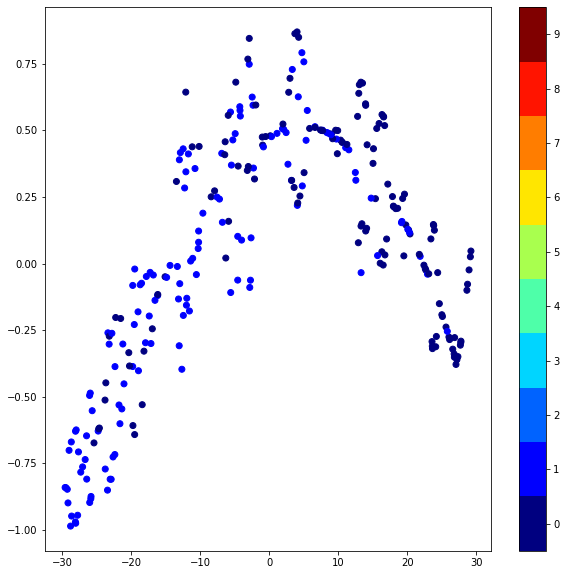

INFO flwr 2023-12-13 14:17:01,609 | server.py:125 | fit progress: (30, 0.028217773139476775, {'global_accuracy': 0.8321428571428572}, 550.149328999978)
DEBUG flwr 2023-12-13 14:17:01,610 | server.py:173 | evaluate_round 30: strategy sampled 5 clients (out of 5)


(DefaultActor pid=67176) Client 2: evaluate
(DefaultActor pid=67176) Client 3: evaluate
(DefaultActor pid=67176) Client 0: evaluate
(DefaultActor pid=67176) Client 4: evaluate
(DefaultActor pid=67176) Client 1: evaluate


DEBUG flwr 2023-12-13 14:17:08,366 | server.py:187 | evaluate_round 30 received 5 results and 0 failures
DEBUG flwr 2023-12-13 14:17:08,366 | server.py:222 | fit_round 31: strategy sampled 5 clients (out of 5)


(DefaultActor pid=67176) Client 1: fit
(DefaultActor pid=67176) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 31}
(DefaultActor pid=67176) Epoch 1: train loss 0.01699729822576046, accuracy 0.89375
(DefaultActor pid=67176) Weight Averaging......
(DefaultActor pid=67176) Original Weight Averaging Accuracy:  0.9125
(DefaultActor pid=67176) Updated Weight Averaging Accuracy:  0.9
(DefaultActor pid=67176) Remain the same Personalized Global Model.
(DefaultActor pid=67176) Client 3: fit
(DefaultActor pid=67176) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 31}
(DefaultActor pid=67176) Epoch 1: train loss 0.012060040608048439, accuracy 0.9291666666666667
(DefaultActor pid=67176) Weight Averaging......
(DefaultActor pid=67176) Original Weight Averaging Accuracy:  0.9375
(DefaultActor pid=67176) Updated Weight Averaging Accuracy:  0.73125
(DefaultActor pid=67176) Remain the same Personalized Global Model.
(DefaultActor pid=67176) Client 0: fit
(DefaultActor pid=67176) {'alpha': 0.75

DEBUG flwr 2023-12-13 14:17:19,901 | server.py:236 | fit_round 31 received 5 results and 0 failures


(DefaultActor pid=67176) Original Weight Averaging Accuracy:  0.9125
(DefaultActor pid=67176) Updated Weight Averaging Accuracy:  0.8625
(DefaultActor pid=67176) Remain the same Personalized Global Model.


INFO flwr 2023-12-13 14:17:20,427 | server.py:125 | fit progress: (31, 0.030905058022056307, {'global_accuracy': 0.7642857142857142}, 568.9671673999983)
DEBUG flwr 2023-12-13 14:17:20,428 | server.py:173 | evaluate_round 31: strategy sampled 5 clients (out of 5)


(DefaultActor pid=67176) Client 3: evaluate
(DefaultActor pid=67176) Client 0: evaluate
(DefaultActor pid=67176) Client 2: evaluate
(DefaultActor pid=67176) Client 4: evaluate


DEBUG flwr 2023-12-13 14:17:27,182 | server.py:187 | evaluate_round 31 received 5 results and 0 failures
DEBUG flwr 2023-12-13 14:17:27,183 | server.py:222 | fit_round 32: strategy sampled 5 clients (out of 5)


(DefaultActor pid=67176) Client 1: evaluate
(DefaultActor pid=67176) Client 0: fit
(DefaultActor pid=67176) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 32}
(DefaultActor pid=67176) Epoch 1: train loss 0.007891080342233181, accuracy 0.9520833333333333
(DefaultActor pid=67176) Weight Averaging......
(DefaultActor pid=67176) Original Weight Averaging Accuracy:  0.83125
(DefaultActor pid=67176) Updated Weight Averaging Accuracy:  0.5
(DefaultActor pid=67176) Remain the same Personalized Global Model.
(DefaultActor pid=67176) Client 1: fit
(DefaultActor pid=67176) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 32}
(DefaultActor pid=67176) Epoch 1: train loss 0.014403611421585083, accuracy 0.9125
(DefaultActor pid=67176) Weight Averaging......
(DefaultActor pid=67176) Original Weight Averaging Accuracy:  0.9375
(DefaultActor pid=67176) Updated Weight Averaging Accuracy:  0.81875
(DefaultActor pid=67176) Remain the same Personalized Global Model.
(DefaultActor pid=67176) Client 3

DEBUG flwr 2023-12-13 14:17:38,663 | server.py:236 | fit_round 32 received 5 results and 0 failures


(DefaultActor pid=67176) Original Weight Averaging Accuracy:  0.925
(DefaultActor pid=67176) Updated Weight Averaging Accuracy:  0.93125
(DefaultActor pid=67176) Update Personalized Global Model......
(DefaultActor pid=67176) Personalized Global Model Num:  1


INFO flwr 2023-12-13 14:17:39,213 | server.py:125 | fit progress: (32, 0.022239626651363715, {'global_accuracy': 0.8464285714285714}, 587.7530421999982)
DEBUG flwr 2023-12-13 14:17:39,214 | server.py:173 | evaluate_round 32: strategy sampled 5 clients (out of 5)


(DefaultActor pid=67176) Client 0: evaluate
(DefaultActor pid=67176) Client 3: evaluate
(DefaultActor pid=67176) Client 4: evaluate
(DefaultActor pid=67176) Client 1: evaluate


DEBUG flwr 2023-12-13 14:17:46,176 | server.py:187 | evaluate_round 32 received 5 results and 0 failures


(DefaultActor pid=67176) Client 2: evaluate


DEBUG flwr 2023-12-13 14:17:46,177 | server.py:222 | fit_round 33: strategy sampled 5 clients (out of 5)


(DefaultActor pid=67176) Client 0: fit
(DefaultActor pid=67176) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 33}
(DefaultActor pid=67176) Epoch 1: train loss 0.007195792626589537, accuracy 0.95625
(DefaultActor pid=67176) Weight Averaging......
(DefaultActor pid=67176) Original Weight Averaging Accuracy:  0.84375
(DefaultActor pid=67176) Updated Weight Averaging Accuracy:  0.5
(DefaultActor pid=67176) Remain the same Personalized Global Model.
(DefaultActor pid=67176) Client 1: fit
(DefaultActor pid=67176) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 33}
(DefaultActor pid=67176) Epoch 1: train loss 0.011569753289222717, accuracy 0.9354166666666667
(DefaultActor pid=67176) Weight Averaging......
(DefaultActor pid=67176) Original Weight Averaging Accuracy:  0.94375
(DefaultActor pid=67176) Updated Weight Averaging Accuracy:  0.83125
(DefaultActor pid=67176) Remain the same Personalized Global Model.
(DefaultActor pid=67176) Client 2: fit
(DefaultActor pid=67176) {'alpha': 0

DEBUG flwr 2023-12-13 14:17:59,456 | server.py:236 | fit_round 33 received 5 results and 0 failures


(DefaultActor pid=67176) Original Weight Averaging Accuracy:  0.93125
(DefaultActor pid=67176) Updated Weight Averaging Accuracy:  0.625
(DefaultActor pid=67176) Remain the same Personalized Global Model.


INFO flwr 2023-12-13 14:18:00,028 | server.py:125 | fit progress: (33, 0.024218149722686835, {'global_accuracy': 0.8464285714285714}, 608.5679861999815)
DEBUG flwr 2023-12-13 14:18:00,030 | server.py:173 | evaluate_round 33: strategy sampled 5 clients (out of 5)


(DefaultActor pid=67176) Client 1: evaluate
(DefaultActor pid=67176) Client 3: evaluate
(DefaultActor pid=67176) Client 4: evaluate
(DefaultActor pid=67176) Client 2: evaluate


DEBUG flwr 2023-12-13 14:18:06,616 | server.py:187 | evaluate_round 33 received 5 results and 0 failures
DEBUG flwr 2023-12-13 14:18:06,617 | server.py:222 | fit_round 34: strategy sampled 5 clients (out of 5)


(DefaultActor pid=67176) Client 0: evaluate
(DefaultActor pid=67176) Client 1: fit
(DefaultActor pid=67176) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 34}
(DefaultActor pid=67176) Epoch 1: train loss 0.012402723543345928, accuracy 0.9354166666666667
(DefaultActor pid=67176) Weight Averaging......
(DefaultActor pid=67176) Original Weight Averaging Accuracy:  0.9375
(DefaultActor pid=67176) Updated Weight Averaging Accuracy:  0.89375
(DefaultActor pid=67176) Remain the same Personalized Global Model.
(DefaultActor pid=67176) Client 4: fit
(DefaultActor pid=67176) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 34}
(DefaultActor pid=67176) Epoch 1: train loss 0.018429551273584366, accuracy 0.8666666666666667
(DefaultActor pid=67176) Weight Averaging......
(DefaultActor pid=67176) Original Weight Averaging Accuracy:  0.91875
(DefaultActor pid=67176) Updated Weight Averaging Accuracy:  0.75625
(DefaultActor pid=67176) Remain the same Personalized Global Model.
(DefaultActor pid

DEBUG flwr 2023-12-13 14:18:18,480 | server.py:236 | fit_round 34 received 5 results and 0 failures
INFO flwr 2023-12-13 14:18:19,085 | server.py:125 | fit progress: (34, 0.02911137148205723, {'global_accuracy': 0.8107142857142857}, 627.6248129999731)
DEBUG flwr 2023-12-13 14:18:19,087 | server.py:173 | evaluate_round 34: strategy sampled 5 clients (out of 5)


(DefaultActor pid=67176) Client 1: evaluate
(DefaultActor pid=67176) Client 4: evaluate
(DefaultActor pid=67176) Client 0: evaluate
(DefaultActor pid=67176) Client 2: evaluate


DEBUG flwr 2023-12-13 14:18:25,624 | server.py:187 | evaluate_round 34 received 5 results and 0 failures
DEBUG flwr 2023-12-13 14:18:25,625 | server.py:222 | fit_round 35: strategy sampled 5 clients (out of 5)


(DefaultActor pid=67176) Client 3: evaluate
(DefaultActor pid=67176) Client 2: fit
(DefaultActor pid=67176) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 35}
(DefaultActor pid=67176) Epoch 1: train loss 0.010063090361654758, accuracy 0.9458333333333333
(DefaultActor pid=67176) Weight Averaging......
(DefaultActor pid=67176) Original Weight Averaging Accuracy:  0.925
(DefaultActor pid=67176) Updated Weight Averaging Accuracy:  0.91875
(DefaultActor pid=67176) Remain the same Personalized Global Model.
(DefaultActor pid=67176) Client 3: fit
(DefaultActor pid=67176) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 35}
(DefaultActor pid=67176) Epoch 1: train loss 0.01004758570343256, accuracy 0.9458333333333333
(DefaultActor pid=67176) Weight Averaging......
(DefaultActor pid=67176) Original Weight Averaging Accuracy:  0.90625
(DefaultActor pid=67176) Updated Weight Averaging Accuracy:  0.80625
(DefaultActor pid=67176) Remain the same Personalized Global Model.
(DefaultActor pid=6

DEBUG flwr 2023-12-13 14:18:37,457 | server.py:236 | fit_round 35 received 5 results and 0 failures


(DefaultActor pid=67176) Original Weight Averaging Accuracy:  0.8875
(DefaultActor pid=67176) Updated Weight Averaging Accuracy:  0.70625
(DefaultActor pid=67176) Remain the same Personalized Global Model.


INFO flwr 2023-12-13 14:18:38,013 | server.py:125 | fit progress: (35, 0.020315028860100677, {'global_accuracy': 0.8678571428571429}, 646.552523099992)
DEBUG flwr 2023-12-13 14:18:38,014 | server.py:173 | evaluate_round 35: strategy sampled 5 clients (out of 5)


(DefaultActor pid=67176) Client 2: evaluate
(DefaultActor pid=67176) Client 1: evaluate
(DefaultActor pid=67176) Client 0: evaluate
(DefaultActor pid=67176) Client 4: evaluate


DEBUG flwr 2023-12-13 14:18:44,723 | server.py:187 | evaluate_round 35 received 5 results and 0 failures
DEBUG flwr 2023-12-13 14:18:44,725 | server.py:222 | fit_round 36: strategy sampled 5 clients (out of 5)


(DefaultActor pid=67176) Client 3: evaluate
(DefaultActor pid=67176) Client 3: fit
(DefaultActor pid=67176) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 36}
(DefaultActor pid=67176) Epoch 1: train loss 0.010393070057034492, accuracy 0.9354166666666667
(DefaultActor pid=67176) Weight Averaging......
(DefaultActor pid=67176) Original Weight Averaging Accuracy:  0.9375
(DefaultActor pid=67176) Updated Weight Averaging Accuracy:  0.79375
(DefaultActor pid=67176) Remain the same Personalized Global Model.
(DefaultActor pid=67176) Client 4: fit
(DefaultActor pid=67176) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 36}
(DefaultActor pid=67176) Epoch 1: train loss 0.015669388696551323, accuracy 0.9
(DefaultActor pid=67176) Weight Averaging......
(DefaultActor pid=67176) Original Weight Averaging Accuracy:  0.90625
(DefaultActor pid=67176) Updated Weight Averaging Accuracy:  0.86875
(DefaultActor pid=67176) Remain the same Personalized Global Model.
(DefaultActor pid=67176) Client 

DEBUG flwr 2023-12-13 14:18:56,975 | server.py:236 | fit_round 36 received 5 results and 0 failures


(DefaultActor pid=67176) Original Weight Averaging Accuracy:  0.925
(DefaultActor pid=67176) Updated Weight Averaging Accuracy:  0.875
(DefaultActor pid=67176) Remain the same Personalized Global Model.


INFO flwr 2023-12-13 14:18:57,516 | server.py:125 | fit progress: (36, 0.026380208666835513, {'global_accuracy': 0.8178571428571428}, 666.0556436000043)
DEBUG flwr 2023-12-13 14:18:57,518 | server.py:173 | evaluate_round 36: strategy sampled 5 clients (out of 5)


(DefaultActor pid=67176) Client 3: evaluate
(DefaultActor pid=67176) Client 2: evaluate
(DefaultActor pid=67176) Client 1: evaluate
(DefaultActor pid=67176) Client 0: evaluate


DEBUG flwr 2023-12-13 14:19:04,140 | server.py:187 | evaluate_round 36 received 5 results and 0 failures
DEBUG flwr 2023-12-13 14:19:04,141 | server.py:222 | fit_round 37: strategy sampled 5 clients (out of 5)


(DefaultActor pid=67176) Client 4: evaluate
(DefaultActor pid=67176) Client 0: fit
(DefaultActor pid=67176) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 37}
(DefaultActor pid=67176) Epoch 1: train loss 0.008293675258755684, accuracy 0.95625
(DefaultActor pid=67176) Weight Averaging......
(DefaultActor pid=67176) Original Weight Averaging Accuracy:  0.875
(DefaultActor pid=67176) Updated Weight Averaging Accuracy:  0.5
(DefaultActor pid=67176) Remain the same Personalized Global Model.
(DefaultActor pid=67176) Client 3: fit
(DefaultActor pid=67176) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 37}
(DefaultActor pid=67176) Epoch 1: train loss 0.014307052828371525, accuracy 0.9145833333333333
(DefaultActor pid=67176) Weight Averaging......
(DefaultActor pid=67176) Original Weight Averaging Accuracy:  0.91875
(DefaultActor pid=67176) Updated Weight Averaging Accuracy:  0.8875
(DefaultActor pid=67176) Remain the same Personalized Global Model.
(DefaultActor pid=67176) Client 2:

DEBUG flwr 2023-12-13 14:19:15,907 | server.py:236 | fit_round 37 received 5 results and 0 failures


(DefaultActor pid=67176) Original Weight Averaging Accuracy:  0.85625
(DefaultActor pid=67176) Updated Weight Averaging Accuracy:  0.88125
(DefaultActor pid=67176) Update Personalized Global Model......
(DefaultActor pid=67176) Personalized Global Model Num:  1


INFO flwr 2023-12-13 14:19:16,460 | server.py:125 | fit progress: (37, 0.022981462547821657, {'global_accuracy': 0.85}, 684.9997990999836)
DEBUG flwr 2023-12-13 14:19:16,462 | server.py:173 | evaluate_round 37: strategy sampled 5 clients (out of 5)


(DefaultActor pid=67176) Client 1: evaluate
(DefaultActor pid=67176) Client 4: evaluate
(DefaultActor pid=67176) Client 3: evaluate
(DefaultActor pid=67176) Client 0: evaluate


DEBUG flwr 2023-12-13 14:19:23,238 | server.py:187 | evaluate_round 37 received 5 results and 0 failures
DEBUG flwr 2023-12-13 14:19:23,239 | server.py:222 | fit_round 38: strategy sampled 5 clients (out of 5)


(DefaultActor pid=67176) Client 2: evaluate
(DefaultActor pid=67176) Client 4: fit
(DefaultActor pid=67176) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 38}
(DefaultActor pid=67176) Epoch 1: train loss 0.01709972880780697, accuracy 0.8875
(DefaultActor pid=67176) Weight Averaging......
(DefaultActor pid=67176) Original Weight Averaging Accuracy:  0.90625
(DefaultActor pid=67176) Updated Weight Averaging Accuracy:  0.8625
(DefaultActor pid=67176) Remain the same Personalized Global Model.
(DefaultActor pid=67176) Client 1: fit
(DefaultActor pid=67176) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 38}
(DefaultActor pid=67176) Epoch 1: train loss 0.012432699091732502, accuracy 0.9291666666666667
(DefaultActor pid=67176) Weight Averaging......
(DefaultActor pid=67176) Original Weight Averaging Accuracy:  0.94375
(DefaultActor pid=67176) Updated Weight Averaging Accuracy:  0.90625
(DefaultActor pid=67176) Remain the same Personalized Global Model.
(DefaultActor pid=67176) Clien

DEBUG flwr 2023-12-13 14:19:35,354 | server.py:236 | fit_round 38 received 5 results and 0 failures


(DefaultActor pid=67176) Original Weight Averaging Accuracy:  0.95
(DefaultActor pid=67176) Updated Weight Averaging Accuracy:  0.68125
(DefaultActor pid=67176) Remain the same Personalized Global Model.


INFO flwr 2023-12-13 14:19:35,963 | server.py:125 | fit progress: (38, 0.021933284827641078, {'global_accuracy': 0.8321428571428572}, 704.5024058999843)
DEBUG flwr 2023-12-13 14:19:35,964 | server.py:173 | evaluate_round 38: strategy sampled 5 clients (out of 5)


(DefaultActor pid=67176) Client 0: evaluate
(DefaultActor pid=67176) Client 4: evaluate
(DefaultActor pid=67176) Client 1: evaluate
(DefaultActor pid=67176) Client 2: evaluate
(DefaultActor pid=67176) Client 3: evaluate


DEBUG flwr 2023-12-13 14:19:42,739 | server.py:187 | evaluate_round 38 received 5 results and 0 failures
DEBUG flwr 2023-12-13 14:19:42,745 | server.py:222 | fit_round 39: strategy sampled 5 clients (out of 5)


(DefaultActor pid=67176) Client 2: fit
(DefaultActor pid=67176) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 39}
(DefaultActor pid=67176) Epoch 1: train loss 0.01165448036044836, accuracy 0.9375
(DefaultActor pid=67176) Weight Averaging......
(DefaultActor pid=67176) Original Weight Averaging Accuracy:  0.925
(DefaultActor pid=67176) Updated Weight Averaging Accuracy:  0.9125
(DefaultActor pid=67176) Remain the same Personalized Global Model.
(DefaultActor pid=67176) Client 1: fit
(DefaultActor pid=67176) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 39}
(DefaultActor pid=67176) Epoch 1: train loss 0.015582781285047531, accuracy 0.9041666666666667
(DefaultActor pid=67176) Weight Averaging......
(DefaultActor pid=67176) Original Weight Averaging Accuracy:  0.94375
(DefaultActor pid=67176) Updated Weight Averaging Accuracy:  0.9
(DefaultActor pid=67176) Remain the same Personalized Global Model.
(DefaultActor pid=67176) Client 3: fit
(DefaultActor pid=67176) {'alpha': 0.75, 

DEBUG flwr 2023-12-13 14:19:55,339 | server.py:236 | fit_round 39 received 5 results and 0 failures


(DefaultActor pid=67176) Original Weight Averaging Accuracy:  0.86875
(DefaultActor pid=67176) Updated Weight Averaging Accuracy:  0.5
(DefaultActor pid=67176) Remain the same Personalized Global Model.


INFO flwr 2023-12-13 14:19:56,017 | server.py:125 | fit progress: (39, 0.018810170170451914, {'global_accuracy': 0.8607142857142858}, 724.5574197999667)
DEBUG flwr 2023-12-13 14:19:56,019 | server.py:173 | evaluate_round 39: strategy sampled 5 clients (out of 5)


(DefaultActor pid=67176) Client 0: evaluate
(DefaultActor pid=67176) Client 1: evaluate
(DefaultActor pid=67176) Client 3: evaluate
(DefaultActor pid=67176) Client 2: evaluate


DEBUG flwr 2023-12-13 14:20:02,838 | server.py:187 | evaluate_round 39 received 5 results and 0 failures


(DefaultActor pid=67176) Client 4: evaluate


DEBUG flwr 2023-12-13 14:20:02,839 | server.py:222 | fit_round 40: strategy sampled 5 clients (out of 5)


(DefaultActor pid=67176) Client 3: fit
(DefaultActor pid=67176) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 40}
(DefaultActor pid=67176) Epoch 1: train loss 0.012076246552169323, accuracy 0.93125
(DefaultActor pid=67176) Weight Averaging......
(DefaultActor pid=67176) Original Weight Averaging Accuracy:  0.9125
(DefaultActor pid=67176) Updated Weight Averaging Accuracy:  0.9
(DefaultActor pid=67176) Remain the same Personalized Global Model.
(DefaultActor pid=67176) Client 1: fit
(DefaultActor pid=67176) {'alpha': 0.75, 'total_rounds': 40, 'server_round': 40}
(DefaultActor pid=67176) Epoch 1: train loss 0.010495465248823166, accuracy 0.9520833333333333
(DefaultActor pid=67176) Weight Averaging......
(DefaultActor pid=67176) Original Weight Averaging Accuracy:  0.94375
(DefaultActor pid=67176) Updated Weight Averaging Accuracy:  0.86875
(DefaultActor pid=67176) Remain the same Personalized Global Model.
(DefaultActor pid=67176) Client 4: fit
(DefaultActor pid=67176) {'alpha': 0.

DEBUG flwr 2023-12-13 14:20:15,005 | server.py:236 | fit_round 40 received 5 results and 0 failures


(DefaultActor pid=67176) Original Weight Averaging Accuracy:  0.93125
(DefaultActor pid=67176) Updated Weight Averaging Accuracy:  0.9125
(DefaultActor pid=67176) Remain the same Personalized Global Model.


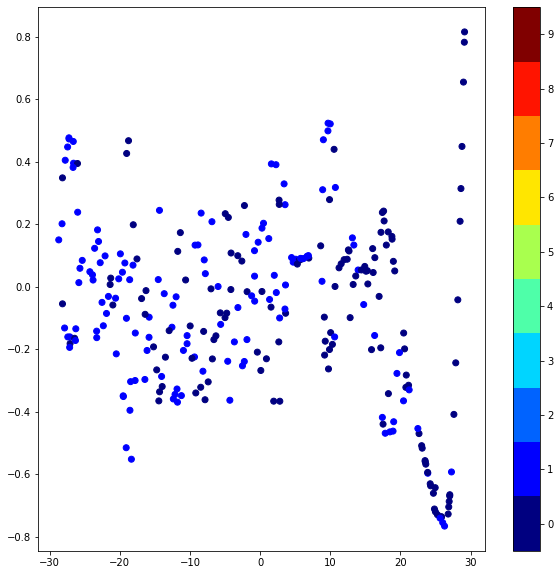

INFO flwr 2023-12-13 14:20:17,166 | server.py:125 | fit progress: (40, 0.02732392493635416, {'global_accuracy': 0.8035714285714286}, 745.7064355000039)
DEBUG flwr 2023-12-13 14:20:17,168 | server.py:173 | evaluate_round 40: strategy sampled 5 clients (out of 5)


(DefaultActor pid=67176) Client 2: evaluate
(DefaultActor pid=67176) Client 0: evaluate
(DefaultActor pid=67176) Client 3: evaluate
(DefaultActor pid=67176) Client 1: evaluate


DEBUG flwr 2023-12-13 14:20:24,309 | server.py:187 | evaluate_round 40 received 5 results and 0 failures


(DefaultActor pid=67176) Client 4: evaluate


INFO flwr 2023-12-13 14:20:24,310 | server.py:153 | FL finished in 752.8498560999869
INFO flwr 2023-12-13 14:20:24,322 | app.py:226 | app_fit: losses_distributed [(1, 0.06527435902506112), (2, 0.038052236251533034), (3, 0.04343400178477168), (4, 0.041577758379280565), (5, 0.03486351475119591), (6, 0.033104346115142104), (7, 0.030750885577872394), (8, 0.032664679065346716), (9, 0.030228759404271843), (10, 0.03240482746623456), (11, 0.03464449468068778), (12, 0.03225935799069703), (13, 0.033558338237926366), (14, 0.03255210624076426), (15, 0.03350910446606577), (16, 0.03723901761695743), (17, 0.032137321112677454), (18, 0.03316903171595186), (19, 0.027716606324538588), (20, 0.030319990245625376), (21, 0.035554275047034026), (22, 0.028378921216353773), (23, 0.030716636776924135), (24, 0.03569944802671671), (25, 0.02728526096791029), (26, 0.028028967389836908), (27, 0.03707587824203074), (28, 0.03171461423393339), (29, 0.02478927097748965), (30, 0.03911320630926639), (31, 0.039788967636413

History (loss, distributed):
	round 1: 0.06527435902506112
	round 2: 0.038052236251533034
	round 3: 0.04343400178477168
	round 4: 0.041577758379280565
	round 5: 0.03486351475119591
	round 6: 0.033104346115142104
	round 7: 0.030750885577872394
	round 8: 0.032664679065346716
	round 9: 0.030228759404271843
	round 10: 0.03240482746623456
	round 11: 0.03464449468068778
	round 12: 0.03225935799069703
	round 13: 0.033558338237926366
	round 14: 0.03255210624076426
	round 15: 0.03350910446606577
	round 16: 0.03723901761695743
	round 17: 0.032137321112677454
	round 18: 0.03316903171595186
	round 19: 0.027716606324538588
	round 20: 0.030319990245625376
	round 21: 0.035554275047034026
	round 22: 0.028378921216353773
	round 23: 0.030716636776924135
	round 24: 0.03569944802671671
	round 25: 0.02728526096791029
	round 26: 0.028028967389836908
	round 27: 0.03707587824203074
	round 28: 0.03171461423393339
	round 29: 0.02478927097748965
	round 30: 0.03911320630926639
	round 31: 0.039788967636413874
	rou

In [112]:
# Specify client resources if you need GPU (defaults to 1 CPU and 0 GPU)
client_resources = None
if DEVICE.type == "cuda":
    client_resources = {"num_gpus": 1}
total_rounds = 40
alpha = 0.75
tsnes = []
global_last_model = None
model = resnet18().to(DEVICE)
model_parameters = get_weights(model)
model_parameters = fl.common.ndarrays_to_parameters(model_parameters)
hist = fl.simulation.start_simulation(
    client_fn=numpyclient_fn,
    num_clients=NUM_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=total_rounds),
    client_resources=client_resources,
    strategy=fl.server.strategy.FedAvg(
        evaluate_metrics_aggregation_fn=weighted_average,
        on_fit_config_fn=get_on_fit_config_fn(total_rounds, alpha),
        evaluate_fn=get_evaluate_fn(model),
        initial_parameters=model_parameters,
        ),
    
)

print(hist)

In [113]:
dict1 = {'accuracy': [(1, 0.5), (2, 0.5957142857142858), (3, 0.6399999999999999), (4, 0.5864285714285715), (5, 0.71), (6, 0.7642857142857143), (7, 0.7757142857142857), (8, 0.825), (9, 0.807142857142857), (10, 0.7542857142857143), (11, 0.8128571428571428), (12, 0.7885714285714286), (13, 0.7785714285714286), (14, 0.8064285714285714), (15, 0.7828571428571428), (16, 0.8378571428571429), (17, 0.8242857142857143), (18, 0.747142857142857), (19, 0.8285714285714287), (20, 0.7978571428571428), (21, 0.8728571428571428), (22, 0.8085714285714286), (23, 0.8092857142857143), (24, 0.817857142857143), (25, 0.7828571428571428), (26, 0.7978571428571429), (27, 0.8014285714285715), (28, 0.7171428571428572), (29, 0.772142857142857), (30, 0.8114285714285714), (31, 0.8678571428571429), (32, 0.8242857142857143), (33, 0.8307142857142856), (34, 0.8521428571428572), (35, 0.7978571428571428), (36, 0.7735714285714287), (37, 0.8221428571428572), (38, 0.7171428571428572), (39, 0.817857142857143), (40, 0.7921428571428571), (41, 0.7849999999999999), (42, 0.8271428571428571), (43, 0.7964285714285715), (44, 0.7), (45, 0.8614285714285714), (46, 0.8257142857142857), (47, 0.7857142857142857), (48, 0.8657142857142857), (49, 0.8442857142857142), (50, 0.7892857142857144), (51, 0.8342857142857143), (52, 0.82), (53, 0.8128571428571428), (54, 0.7878571428571429), (55, 0.8635714285714284), (56, 0.8485714285714285), (57, 0.8535714285714285), (58, 0.8657142857142857), (59, 0.817857142857143), (60, 0.807142857142857), (61, 0.7721428571428572), (62, 0.8242857142857143), (63, 0.8135714285714286), (64, 0.8314285714285715), (65, 0.8664285714285714), (66, 0.8621428571428571), (67, 0.8335714285714286), (68, 0.8164285714285714), (69, 0.8421428571428572), (70, 0.8557142857142856), (71, 0.8542857142857141), (72, 0.8707142857142857), (73, 0.8485714285714285), (74, 0.8007142857142857), (75, 0.8400000000000001), (76, 0.8335714285714286), (77, 0.7285714285714285), (78, 0.8357142857142859), (79, 0.862142857142857), (80, 0.8635714285714287), (81, 0.7557142857142858), (82, 0.8764285714285714), (83, 0.7828571428571428), (84, 0.8771428571428572), (85, 0.8992857142857142), (86, 0.8207142857142857), (87, 0.8221428571428572), (88, 0.9014285714285715), (89, 0.87), (90, 0.8878571428571427), (91, 0.8792857142857143), (92, 0.85), (93, 0.8321428571428571), (94, 0.9014285714285715), (95, 0.8899999999999999), (96, 0.8521428571428571), (97, 0.8571428571428572), (98, 0.9007142857142857), (99, 0.8478571428571428), (100, 0.8135714285714285)]}


dict2 = {'global_accuracy': [(0, 0.0), (1, 0.5), (2, 0.6178571428571429), (3, 0.6678571428571428), (4, 0.5642857142857143), (5, 0.6928571428571428), (6, 0.7678571428571429), (7, 0.8107142857142857), (8, 0.8357142857142857), (9, 0.825), (10, 0.7642857142857142), (11, 0.825), (12, 0.7964285714285714), (13, 0.7857142857142857), (14, 0.8178571428571428), (15, 0.7928571428571428), (16, 0.8428571428571429), (17, 0.8321428571428572), (18, 0.7357142857142858), (19, 0.85), (20, 0.8), (21, 0.8964285714285715), (22, 0.8321428571428572), (23, 0.8357142857142857), (24, 0.8357142857142857), (25, 0.7928571428571428), (26, 0.8214285714285714), (27, 0.825), (28, 0.7071428571428572), (29, 0.775), (30, 0.825), (31, 0.8928571428571429), (32, 0.8392857142857143), (33, 0.8535714285714285), (34, 0.8714285714285714), (35, 0.8178571428571428), (36, 0.7857142857142857), (37, 0.8357142857142857), (38, 0.7392857142857143), (39, 0.8392857142857143), (40, 0.8142857142857143), (41, 0.8035714285714286), (42, 0.85), (43, 0.8142857142857143), (44, 0.7142857142857143), (45, 0.8821428571428571), (46, 0.8428571428571429), (47, 0.8178571428571428), (48, 0.8928571428571429), (49, 0.875), (50, 0.8178571428571428), (51, 0.8607142857142858), (52, 0.8392857142857143), (53, 0.8214285714285714), (54, 0.8), (55, 0.8964285714285715), (56, 0.8607142857142858), (57, 0.8821428571428571), (58, 0.8964285714285715), (59, 0.8535714285714285), (60, 0.8285714285714286), (61, 0.7714285714285715), (62, 0.825), (63, 0.8321428571428572), (64, 0.8642857142857143), (65, 0.9), (66, 0.8857142857142857), (67, 0.8464285714285714), (68, 0.8321428571428572), (69, 0.8571428571428571), (70, 0.8785714285714286), (71, 0.8857142857142857), (72, 0.8892857142857142), (73, 0.8714285714285714), (74, 0.8285714285714286), (75, 0.8642857142857143), (76, 0.8571428571428571), (77, 0.7178571428571429), (78, 0.8642857142857143), (79, 0.8821428571428571), (80, 0.8821428571428571), (81, 0.7428571428571429), (82, 0.9107142857142857), (83, 0.7821428571428571), (84, 0.9142857142857143), (85, 0.9214285714285714), (86, 0.8321428571428572), (87, 0.8357142857142857), (88, 0.925), (89, 0.8964285714285715), (90, 0.9107142857142857), (91, 0.9107142857142857), (92, 0.8785714285714286), (93, 0.8428571428571429), (94, 0.925), (95, 0.9142857142857143), (96, 0.8892857142857142), (97, 0.8928571428571429), (98, 0.9214285714285714), (99, 0.8642857142857143), (100, 0.8178571428571428)]}

dict1 = hist.metrics_distributed
dict2 = hist.metrics_centralized

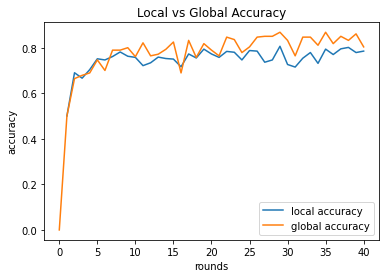

In [114]:
plt.plot([i[0] for i in dict1['accuracy']], [i[1] for i in dict1['accuracy']], label='local accuracy')
plt.plot([i[0] for i in dict2['global_accuracy']], [i[1] for i in dict2['global_accuracy']], label='global accuracy')
plt.legend()
plt.xlabel('rounds')
plt.ylabel('accuracy')
plt.title('Local vs Global Accuracy')
plt.show()

In [115]:
hist.losses_distributed

[(1, 0.06527435902506112),
 (2, 0.038052236251533034),
 (3, 0.04343400178477168),
 (4, 0.041577758379280565),
 (5, 0.03486351475119591),
 (6, 0.033104346115142104),
 (7, 0.030750885577872394),
 (8, 0.032664679065346716),
 (9, 0.030228759404271843),
 (10, 0.03240482746623456),
 (11, 0.03464449468068778),
 (12, 0.03225935799069703),
 (13, 0.033558338237926366),
 (14, 0.03255210624076426),
 (15, 0.03350910446606577),
 (16, 0.03723901761695743),
 (17, 0.032137321112677454),
 (18, 0.03316903171595186),
 (19, 0.027716606324538588),
 (20, 0.030319990245625376),
 (21, 0.035554275047034026),
 (22, 0.028378921216353773),
 (23, 0.030716636776924135),
 (24, 0.03569944802671671),
 (25, 0.02728526096791029),
 (26, 0.028028967389836908),
 (27, 0.03707587824203074),
 (28, 0.03171461423393339),
 (29, 0.02478927097748965),
 (30, 0.03911320630926639),
 (31, 0.039788967636413874),
 (32, 0.031803774158470334),
 (33, 0.0313356946175918),
 (34, 0.03795386660378426),
 (35, 0.029367685366887598),
 (36, 0.03201

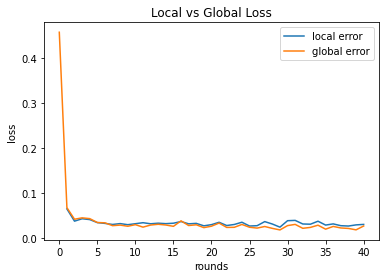

In [116]:
dict1 = hist.losses_distributed
dict2 = hist.losses_centralized
plt.plot([i[0] for i in dict1], [i[1] for i in dict1], label='local error')
plt.plot([i[0] for i in dict2], [i[1] for i in dict2], label='global error')
plt.legend()
plt.xlabel('rounds')
plt.ylabel('loss')
plt.title('Local vs Global Loss')
plt.show()

In [70]:
import json
with open('hist_fedavg_globaltest_camelyon_40.json', 'w') as f:
    json.dump(vars(hist), f)

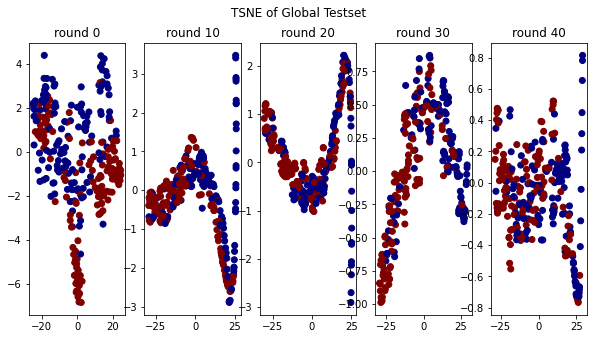

In [118]:
fig, axs = plt.subplots(1,5, figsize=(10, 5))  # 5 rows, 1 column, and figure size of 10x50
for i in range(len(tsnes)):
    axs[i].scatter(tsnes[i][:, 0], tsnes[i][:, 1], label=f'round {i*10}', c = testloaderglobal.dataset.tensors[1].numpy(), cmap=plt.cm.get_cmap("jet", 10))
    #axs[i].legend()
    axs[i].set_title(f'round {i*10}')
fig.suptitle('TSNE of Global Testset')

plt.show()


In [107]:
# save tsnes to file
import pickle
with open('tsnes_fedavg_globaltest_camelyon_40.pkl', 'wb') as f:
    pickle.dump(tsnes, f)

<generator object Module.parameters at 0x000001B952FD8C10>

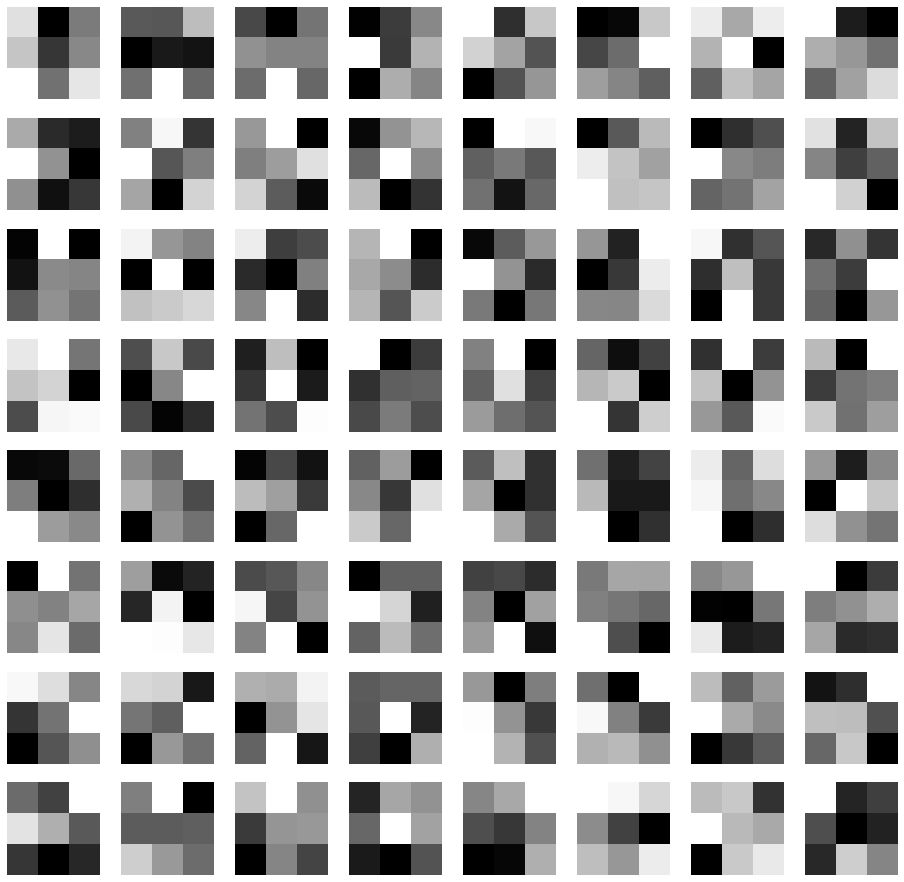

In [165]:
# Access the second convolutional layer of the first block
first_block_conv2 = model.layer1[0].conv2.weight.data.cpu()

# Normalize the filters for better visualization
min_val = torch.min(first_block_conv2)
range_val = torch.max(first_block_conv2) - min_val
normalized_filters = (first_block_conv2 - min_val) / range_val

# Visualize the filters
n_filters = normalized_filters.shape[0]
n_cols = 8  # Adjust the number of columns for your display
n_rows = n_filters // n_cols + 1

plt.figure(figsize=(n_cols * 2, n_rows * 2))
for i in range(n_filters):
    plt.subplot(n_rows, n_cols, i+1)
    # Select a representative slice (channel) of the filter
    filter_slice = normalized_filters[i, 0, :, :]
    plt.imshow(filter_slice, cmap='gray')
    plt.axis('off')

plt.show()


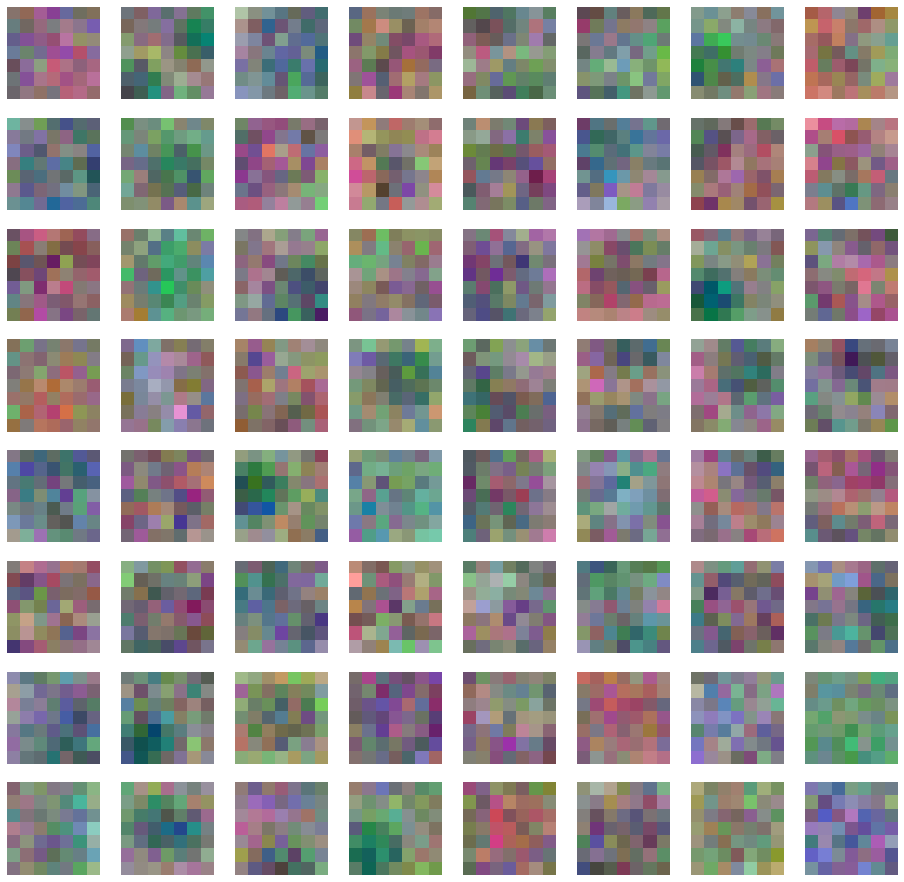

In [160]:
# Access the first convolutional layer
conv1 = global_last_model.conv1.weight.data.cpu()

# Normalize the filters
min_val = torch.min(conv1)
range_val = torch.max(conv1) - min_val
normalized_filters = (conv1 - min_val) / range_val

# Plot the filters
n_filters = normalized_filters.shape[0]
n_cols = 8  # Adjust the number of columns for your display
n_rows = n_filters // n_cols + 1


plt.figure(figsize=(n_cols * 2, n_rows * 2))
for i in range(n_filters):
    plt.subplot(n_rows, n_cols, i+1)
    # Assuming the filters are RGB, otherwise adjust the code
    plt.imshow(normalized_filters[i].permute(1, 2, 0))
    plt.axis('off')


plt.show()

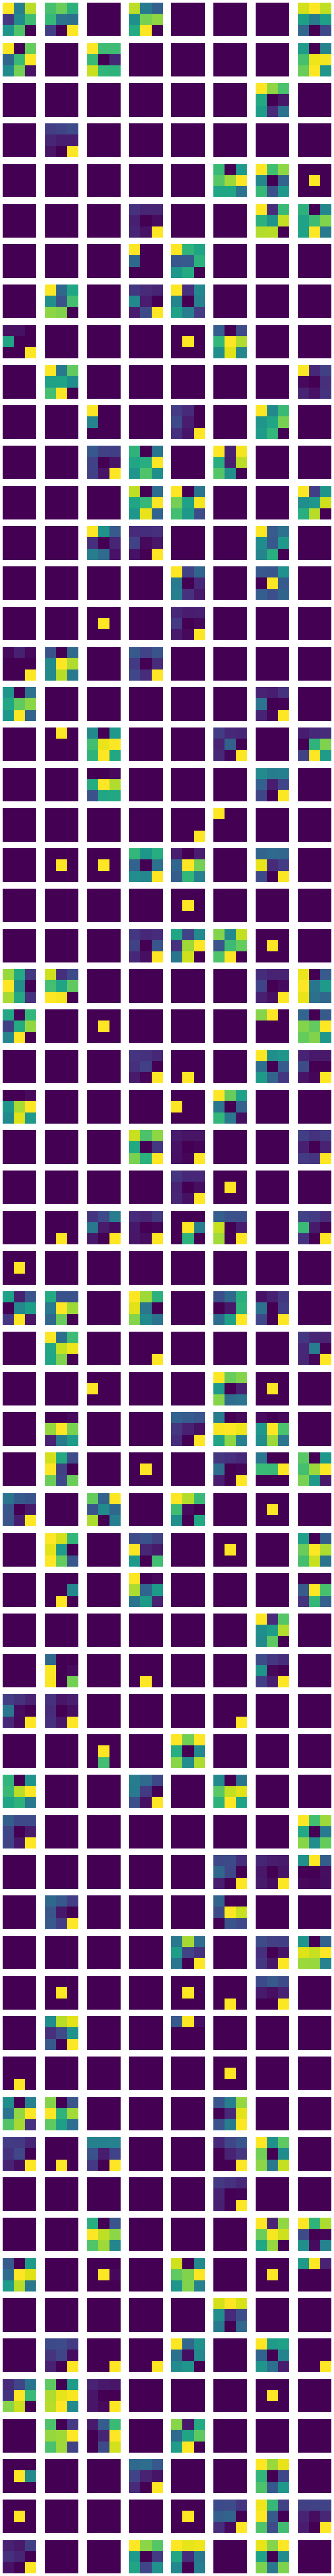

In [170]:
# Function to fetch the activation maps
from PIL import Image
model = global_last_model

activation_maps = []
def get_activation_maps(name):
    def hook(model, input, output):
        activation_maps.append(output.detach())
    return hook

# Choose a high-level layer (e.g., layer4)
model.layer4.register_forward_hook(get_activation_maps('layer4'))

# Load and preprocess an image
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

img = testloaderglobal.dataset.tensors[0][3].unsqueeze(0).to(DEVICE)
# Pass the image through the model
model.eval()
with torch.no_grad():
    _ = model(img)

# Visualize the activation maps
# Assuming you're interested in the first activation map
activations = activation_maps[0].squeeze().cpu()
n_activations = activations.shape[0]

n_cols = 8  # adjust as needed
n_rows = n_activations // n_cols + 1

plt.figure(figsize=(n_cols * 2, n_rows * 2))
for i in range(n_activations):
    plt.subplot(n_rows, n_cols, i+1)
    plt.imshow(activations[i], cmap='viridis')
    plt.axis('off')

plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

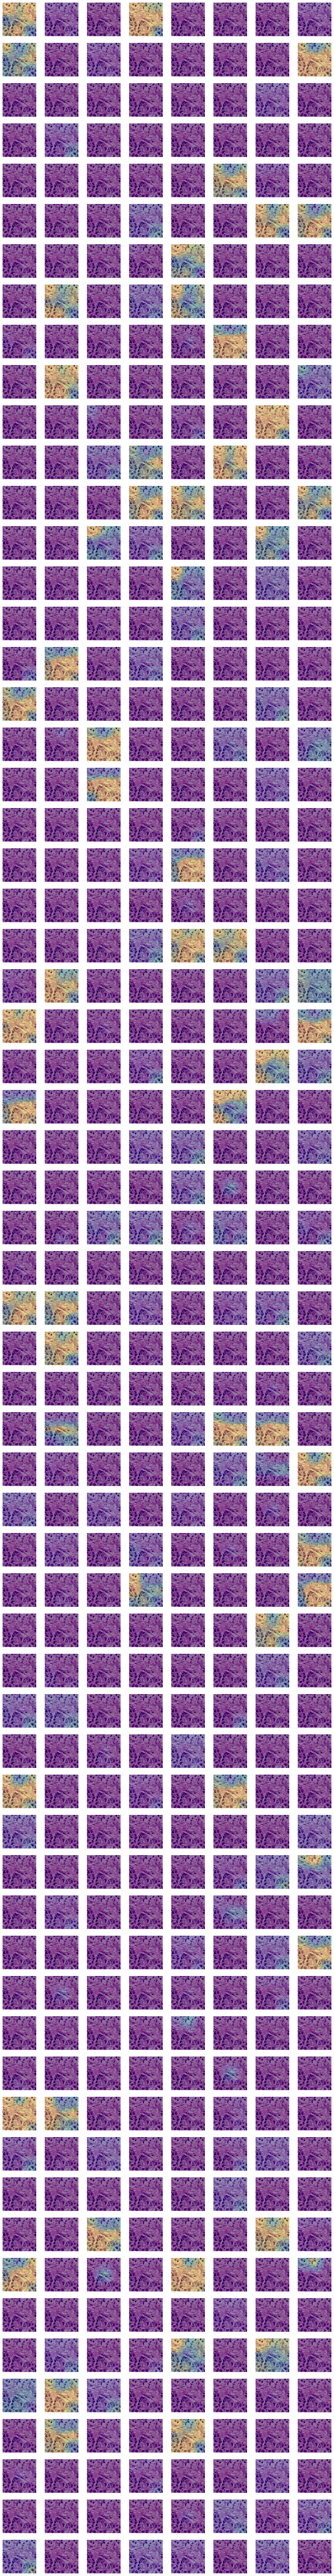

In [171]:
img_tensor = testloaderglobal.dataset.tensors[0][3].unsqueeze(0).to(DEVICE)
# Function to overlay an activation map on the image
def overlay_activation_on_image(activation, original_image, colormap='viridis', alpha=0.4):
    # Resize activation to match the original image size
    activation_resized = torch.nn.functional.interpolate(activation.unsqueeze(0).unsqueeze(0),
                                                         size=original_image.shape[:2],  # Corrected line
                                                         mode='bilinear',
                                                         align_corners=False).squeeze()

    # Convert to numpy and apply colormap
    activation_resized_np = activation_resized.numpy()
    activation_colormap = plt.get_cmap(colormap)(activation_resized_np)
    activation_colormap = np.delete(activation_colormap, 3, 2)  # Remove the alpha channel

    # Overlay the activation map
    overlayed_image = original_image * (1 - alpha) + activation_colormap * alpha
    return overlayed_image

# Rest of your code...

# Convert the tensor image to a NumPy array for overlay
original_image_np = img_tensor.squeeze().cpu().permute(1, 2, 0).numpy()

# Visualization loop (remains the same)
plt.figure(figsize=(n_cols * 2, n_rows * 2))
for i in range(n_activations):
    plt.subplot(n_rows, n_cols, i+1)
    overlayed_image = overlay_activation_on_image(activations[i], original_image_np)
    plt.imshow(overlayed_image)
    plt.axis('off')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


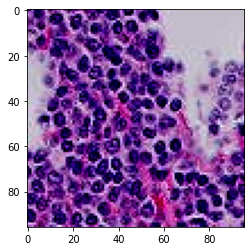

In [139]:
plt.imshow(original_image_np)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


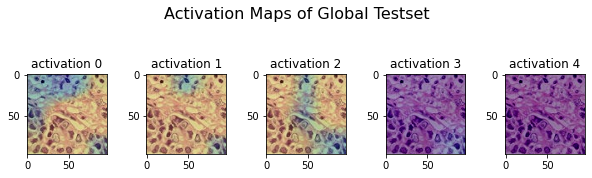

In [183]:
# plot 5 subplots of the first 5 activations
fig, axs = plt.subplots(1,5, figsize=(10, 5))  # 5 rows, 1 column, and figure size of 10x50
for i in range(5):
    # take a random image from the activation maps
    c = np.random.randint(0, activations.shape[0])
    overlayed_image = overlay_activation_on_image(activations[c], original_image_np)
    axs[i].imshow(overlayed_image)
    axs[i].set_title(f'activation {i}')
fig.suptitle('Activation Maps of Global Testset', y=0.8, fontsize=16)
fig.subplots_adjust(wspace=0.5)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


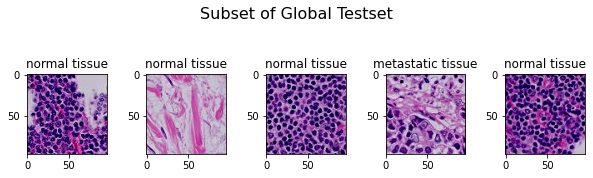

In [168]:
# plot a subset of images of the dataset
fig, axs = plt.subplots(1,5, figsize=(10, 5))  # 5 rows, 1 column, and figure size of 10x50
for i in range(5):
    axs[i].imshow(testloaderglobal.dataset.tensors[0][i].permute(1,2,0))
    # set title to label
    if testloaderglobal.dataset.tensors[1][i] == 0:
        axs[i].set_title(f'normal tissue')
    else:
        axs[i].set_title(f'metastatic tissue')
fig.suptitle('Subset of Global Testset', y=0.8, fontsize=16)
fig.subplots_adjust(wspace=0.5) 
plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


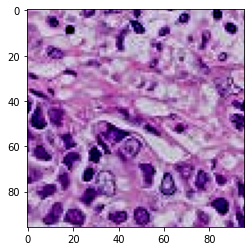

In [169]:
testloaderglobal.dataset.tensors[0][3].permute(1,2,0)